In [48]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_validate, StratifiedKFold, cross_val_predict
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
import time
import lightgbm as lgb
from sklearn.model_selection import train_test_split

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Crimes_2001_to_Present.csv")

print("✅ Veri setinin boyutu (satır, sütun):", df.shape)
print("\n🧾 Sütunlar:")
print(df.columns.tolist())

print("📌 İlk 5 Satır:")
print(df.head())

print("\n🧾 Sütunlar ve Türleri:")
print(df.dtypes)

print("\n🔍 Eksik Değer Sayısı:")
print(df.isnull().sum())

print("\n📈 Sayısal Özet:")
print(df.describe(include='all'))

print("\n🔠 Kategorik değişkenlerin sınıf sayısı:")
cat_cols = df.select_dtypes(include='object').columns
print(df[cat_cols].nunique().sort_values(ascending=False))

✅ Veri setinin boyutu (satır, sütun): (8298827, 22)

🧾 Sütunlar:
['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type', 'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat', 'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate', 'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude', 'Location']
📌 İlk 5 Satır:
         ID Case Number                    Date                    Block  \
0  13311263    JG503434  07/29/2022 03:39:00 AM          023XX S TROY ST   
1  13053066    JG103252  01/03/2023 04:44:00 PM  039XX W WASHINGTON BLVD   
2  11227634    JB147599  08/26/2017 10:00:00 AM      001XX W RANDOLPH ST   
3  13203321    JG415333  09/06/2023 05:00:00 PM         002XX N Wells st   
4  13204489    JG416325  09/06/2023 11:00:00 AM           0000X E 8TH ST   

   IUCR                Primary Type                    Description  \
0  1582  OFFENSE INVOLVING CHILDREN              CHILD PORNOGRAPHY   
1  2017                   NARCOTICS  MANUFACTURE /

Bu aşamada amacım veriyi CSV dosyasından çekmek ve veri setindeki satırları ve sütunları inceleyebilmek. Bu aşamada verimde eksik satırlar var mı, modellemede kullanacağım sütunlar arasında kategorik tipte sütunlar var mı, kullanmak istemediğim satırlar hangileri gibi sorularıma ceavp aradım.

In [13]:
drop_cols = ['ID', 'Case Number', 'Updated On', 'Location',
             'X Coordinate', 'Y Coordinate']
df.drop(columns=drop_cols, inplace=True)

df.dropna(inplace=True)

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.dropna(subset=['Date'], inplace=True)

df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Hour'] = df['Date'].dt.hour
df['Weekday'] = df['Date'].dt.weekday
df['IsWeekend'] = df['Weekday'].isin([5, 6]).astype(int)

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['Season'] = df['Month'].apply(get_season)

def time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df['TimeOfDay'] = df['Hour'].apply(time_of_day)

df.dropna(inplace=True)

df['Arrest'] = df['Arrest'].astype(int)
df['Domestic'] = df['Domestic'].astype(int)

print("✅ Yeni veri seti boyutu:", df.shape)
print("\n📌 Güncellenmiş sütunlar:", df.columns.tolist())
print("\n🧪 Örnek satırlar:")
print(df.head())


<ipython-input-13-b71248a4c8aa>:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_1['Date'] = pd.to_datetime(df_1['Date'], errors='coerce')  # hatalı tarihleri NaT yapar


✅ Yeni veri seti boyutu: (7590980, 23)

📌 Güncellenmiş sütunlar: ['Date', 'Block', 'IUCR', 'Primary Type', 'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat', 'District', 'Ward', 'Community Area', 'FBI Code', 'Year', 'Latitude', 'Longitude', 'Month', 'Day', 'Hour', 'Weekday', 'IsWeekend', 'Season', 'TimeOfDay']

🧪 Örnek satırlar:
                 Date                   Block  IUCR     Primary Type  \
3 2023-09-06 17:00:00        002XX N Wells st  1320  CRIMINAL DAMAGE   
4 2023-09-06 11:00:00          0000X E 8TH ST  0810            THEFT   
5 2019-05-21 08:20:00  018XX S CALIFORNIA AVE  0620         BURGLARY   
6 2021-07-07 10:30:00   132XX S GREENWOOD AVE  1544      SEX OFFENSE   
7 2022-06-14 14:47:00     035XX N CENTRAL AVE  0340          ROBBERY   

                      Description                    Location Description  \
3                      TO VEHICLE  PARKING LOT / GARAGE (NON RESIDENTIAL)   
4                       OVER $500  PARKING LOT / GARAGE (NON RES

Bu aşamadaki amacım ise veri setimle alakalı Feature Engineering aşamasını başlatmaktı. Burada veri setimden hangi kolonları çıkarmam gerekiyor, korelasyonu fazla olan sütunların çıkarılması, modelde kullanılması fayda sağlamayan sütunların çıkarılması, sütunların işlenerek kullanılması daha kolay ve maliyetsiz veri tiplerine ya da yeni kolonlara dönüştürülmesi gibi işlemleri gerçekleştirdim.

In [16]:
df['PrimaryType_Original'] = df['Primary Type']
df['Season_Original'] = df['Season']
df['TimeOfDay_Original'] = df['TimeOfDay']
df['Domestic_Original'] = df['Domestic']
df['IsWeekend_Original'] = df['IsWeekend']

İlerideki aşamalarda yukarıda işlem gerçekleştirdiğim kolonlar veri setinden tamamen siliniyordu. Bunun sebebi ise encoding işleminde kod üzerinde işlem yapılan kolonu doğrudan yeni sütunlara çeviriyor ve saklamıyordu. Bu kolonlara da daha sonraki aşamalarda ihtiyaç duyduğum için encoding yapılan ve ihtiyaç duyduğum kolonları işleme sokmadan önce farklı bir kolon yaratarak sakladım.

In [18]:
le_location = LabelEncoder()
df['Location_Code'] = le_location.fit_transform(df['Location Description'])

le_community = LabelEncoder()
df['CommunityArea_Code'] = le_community.fit_transform(df['Community Area'])

le_primary = LabelEncoder()
df['PrimaryType_encoded'] = le_primary.fit_transform(df['PrimaryType_Original'])

le_IUCR = LabelEncoder()
df['IUCR_encoded'] = le_IUCR.fit_transform(df['IUCR'])

le_FBICode = LabelEncoder()
df['FBICode_encoded'] = le_FBICode.fit_transform(df['FBI Code'])

one_hot_cols = ['Primary Type', 'Domestic', 'IsWeekend', 'Season', 'TimeOfDay']

df = pd.get_dummies(df, columns=one_hot_cols, prefix=one_hot_cols, drop_first=False)

print("✅ Encoding sonrası veri seti boyutu:", df.shape)
print("🆕 Yeni sütunlar:")
for col in df.columns:
    if any(prefix in col for prefix in ['Primary Type_', 'Domestic_', 'IsWeekend_', 'Season_', 'Code']):
        print(col)


✅ Encoding sonrası veri seti boyutu: (7590980, 75)
🆕 Yeni sütunlar:
FBI Code
Season_Original
Domestic_Original
IsWeekend_Original
Location_Code
CommunityArea_Code
FBICode_encoded
Primary Type_ARSON
Primary Type_ASSAULT
Primary Type_BATTERY
Primary Type_BURGLARY
Primary Type_CONCEALED CARRY LICENSE VIOLATION
Primary Type_CRIM SEXUAL ASSAULT
Primary Type_CRIMINAL DAMAGE
Primary Type_CRIMINAL SEXUAL ASSAULT
Primary Type_CRIMINAL TRESPASS
Primary Type_DECEPTIVE PRACTICE
Primary Type_GAMBLING
Primary Type_HOMICIDE
Primary Type_HUMAN TRAFFICKING
Primary Type_INTERFERENCE WITH PUBLIC OFFICER
Primary Type_INTIMIDATION
Primary Type_KIDNAPPING
Primary Type_LIQUOR LAW VIOLATION
Primary Type_MOTOR VEHICLE THEFT
Primary Type_NARCOTICS
Primary Type_NON - CRIMINAL
Primary Type_NON-CRIMINAL
Primary Type_NON-CRIMINAL (SUBJECT SPECIFIED)
Primary Type_OBSCENITY
Primary Type_OFFENSE INVOLVING CHILDREN
Primary Type_OTHER NARCOTIC VIOLATION
Primary Type_OTHER OFFENSE
Primary Type_PROSTITUTION
Primary Type_P

Bu kod bloğunda enoding işlemlerini gerçekleştirdim. Label Encoding doğrudan kolon üzerinde işlemleri gerçekleştiriyor ve her unique değere bir değer atıyor. One-Hot Encoding ise kolondaki her unique değeri ayrı bir kolon olarak kaydediyor ve buna bir değer atıyor. Hangisini neye göre kullanacağıma ise kolondaki unique değer sayısına göre karar verdim. One-Hot Encoding'de eğer ki kolonda çok fazla unique değer varsa kolon sayısı çok artacak ve veri setimizin aşırı şişmesine sebep olacaktı. Ben de bu sebepten çoğu satırda label encoding kullanmayı tercih ettim. Primary Type'ın ise benim modellemem için önemli bir kolon olduğuna karar verdim, bu sebepten One-Hot Encoding uyguladım.

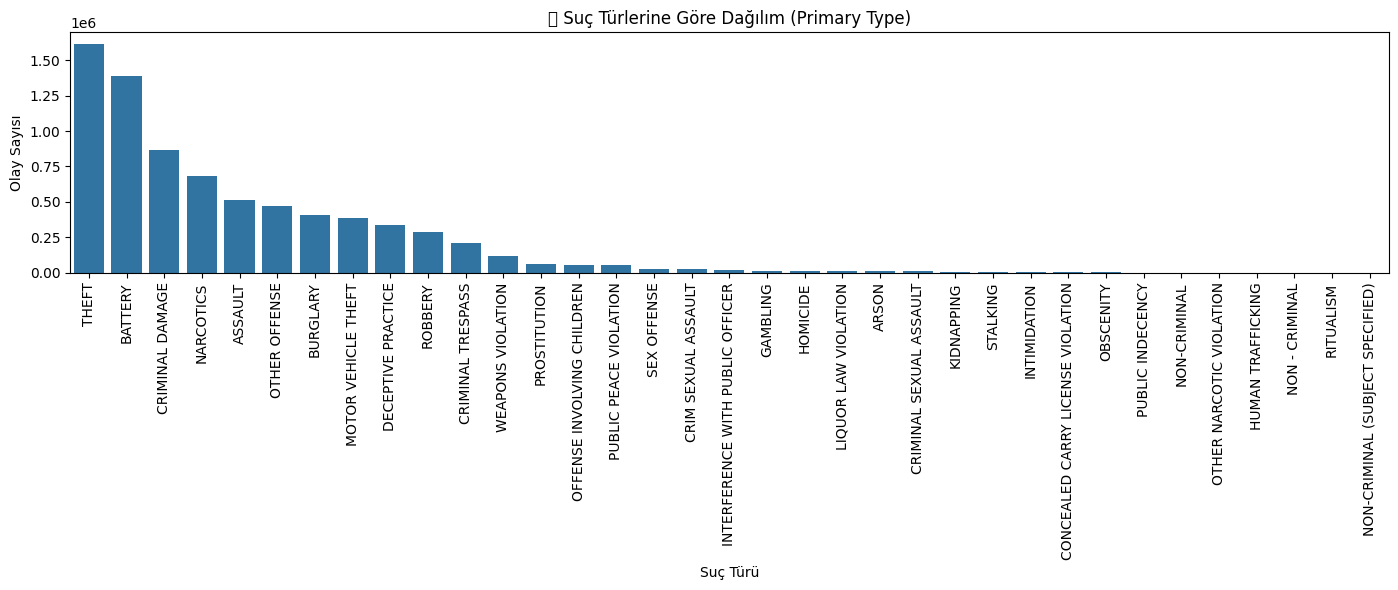

In [47]:
plt.figure(figsize=(14,6))
sns.countplot(data=df, x='PrimaryType_Original', order=df['PrimaryType_Original'].value_counts().index)
plt.xticks(rotation=90)
plt.title('🔍 Suç Türlerine Göre Dağılım (Primary Type)')
plt.ylabel('Olay Sayısı')
plt.xlabel('Suç Türü')
plt.tight_layout()
plt.show()

Bu çubuk grafik, veri setinde bulunan birincil suç türlerinin dağılımını göstermektedir. Grafiğin x ekseni, farklı suç kategorilerini temsil ederken, y ekseni her bir suç türünün kaç kez meydana geldiğini göstermektedir. Grafiğe genel olarak bakıldığında, çoğu şehirde veya ülkede görebileceğimiz gibi "THEFT" suç türünün açık ara en yüksek olay sayısına sahip olduğu görülmektedir; bu, veri setindeki suçların önemli bir kısmının hırsızlık vakalarından oluştuğunu ortaya koymaktadır. "BATTERY" ve "CRIMINAL DAMAGE" suçları da hırsızlıktan sonra yüksek frekansta görülen diğer önemli kategorilerdir. Grafiğin sağ tarafına doğru ilerledikçe, "RITUALISM", "NON-CRIMINAL (SUBJECT SPECIFIED)" gibi suç türlerinin olay sayılarının oldukça düşük olduğu, hatta bazı türlerin neredeyse hiç görülmediği anlaşılmaktadır. Bu dağılım, veri setindeki suç türleri arasında ciddi bir dengesizlik olduğunu ve analizlerde bu dominant suç türlerinin etkisinin göz önünde bulundurulması gerektiğini işaret etmektedir. Ayrıca, bu ön bilgiler, gelecekteki modelleme çalışmalarında sınıf dengesizliği sorununu ele almamız gerektiğini göstermektedir.

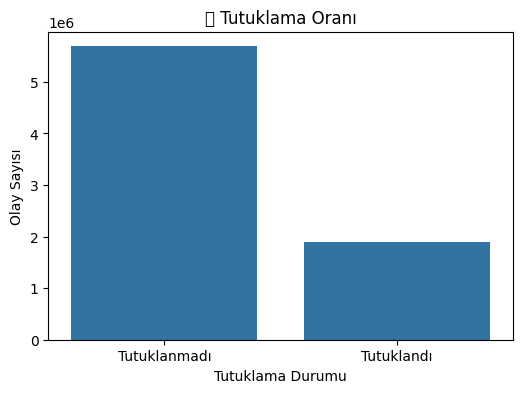

📊 Tutuklama yüzdesi: 25.08 %


In [46]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Arrest')
plt.title('🔒 Tutuklama Oranı')
plt.xticks([0, 1], ['Tutuklanmadı', 'Tutuklandı'])
plt.ylabel('Olay Sayısı')
plt.xlabel('Tutuklama Durumu')
plt.show()

print("📊 Tutuklama yüzdesi:", round(df['Arrest'].mean() * 100, 2), "%")


Bu çubuk grafik, veri setindeki olayların tutuklanma durumlarını ve bu durumların sıklığını ortaya koymaktadır. Grafiğin x ekseni, olayların "Tutuklanmadı" veya "Tutuklandı" olarak iki ana kategoriye ayrıldığını gösterirken, y ekseni her bir durumun kaç kez meydana geldiğini sayısal olarak ifade etmektedir. Grafiğe bakıldığında, "Tutuklanmadı" olarak kaydedilen olay sayısının, "Tutuklandı" olarak kaydedilen olay sayısından belirgin şekilde daha yüksek olduğu görülmektedir. Bu durum, veri setindeki suç vakalarının büyük çoğunluğunun tutuklama ile sonuçlanmadığını göstermektedir. Grafiğin altında ayrıca "Tutuklama yüzdesi: 25.08 %" bilgisi verilmiştir. Bu yüzde, veri setindeki toplam olayların yalnızca yaklaşık dörtte birinin tutuklamayla sonuçlandığını açıkça ortaya koymaktadır. Bu düşük tutuklama oranı, kolluk kuvvetlerinin etkinliği, suçların karmaşıklığı, kanıt yetersizliği veya raporlama biçimi gibi çeşitli faktörlerden kaynaklanabilir. Bu grafikteki bilgiler, gelecekteki analizlerde tutuklama oranını etkileyen faktörleri incelemek veya tutuklanma durumunun diğer değişkenlerle olan ilişkisini keşfetmek için bir başlangıç noktası olabilir. Örneğin, belirli suç türlerinin daha yüksek veya daha düşük tutuklama oranlarına sahip olup olmadığı gibi soruların yanıtları aranabilir.

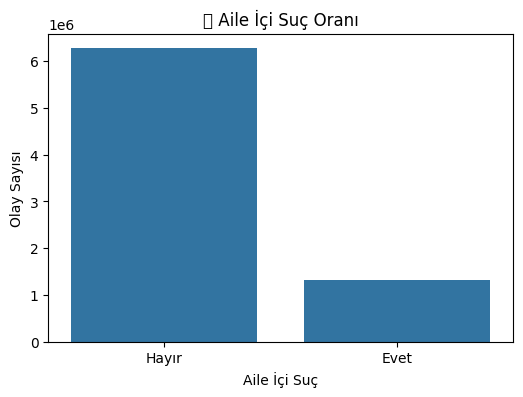

📊 Aile içi suç yüzdesi: 17.38 %


In [45]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Domestic_Original')
plt.title('🏠 Aile İçi Suç Oranı')
plt.xticks([0, 1], ['Hayır', 'Evet'])
plt.ylabel('Olay Sayısı')
plt.xlabel('Aile İçi Suç')
plt.show()

print("📊 Aile içi suç yüzdesi:", round(df['Domestic_Original'].mean() * 100, 2), "%")


Bu çubuk grafik, veri setindeki olayların "Aile İçi Suç" durumu olup olmadığını ve bu durumların frekansını gözler önüne sermektedir. Grafiğin x ekseni, olayların "Aile içi suç değil" veya "Aile içi suç" olarak kategorize edildiğini gösterirken, y ekseni her bir durumun kaç kez meydana geldiğini ifade etmektedir. Grafiğe bakıldığında, "Hayır" kategorisinin "Evet" kategorisinden çok daha yüksek bir olay sayısına sahip olduğu açıkça görülmektedir. Bu durum, veri setindeki suç olaylarının büyük çoğunluğunun aile içi nitelikte olmadığını ortaya koymaktadır. Grafiğin altında ayrıca "Aile içi suç yüzdesi: 17.38 %" bilgisi sunulmuştur. Bu yüzde, veri setindeki toplam olayların yalnızca beşte birinin aile içi suç kategorisine girdiğini göstermektedir. Bu oran benim kişisel görüşüme göre yüksek olsa da önemli olan diğer ülke veya şehirlerin veri setleriyle karşılaştırdığımızda nasıl bir sonuçla karşılaştığımızdır. Bu bulgu, suçların önemli bir kısmının aile dışı ortamlarda meydana geldiğini veya aile içi suçların raporlama mekanizmalarında yeterince yer almadığını düşündürebilir. Bu grafikteki bilgiler, aile içi suçların diğer suç türleriyle olan ilişkilerini, belirli coğrafi bölgelerdeki yoğunluklarını veya zaman içindeki değişimlerini incelemek için değerli bir başlangıç noktası sunmaktadır. Ayrıca, aile içi suç verilerinin özel hassasiyetleri göz önünde bulundurularak, bu kategorideki olaylara yönelik daha derinlemesine analizler yapılması gerektiğinin de bir göstergesi olabilir.

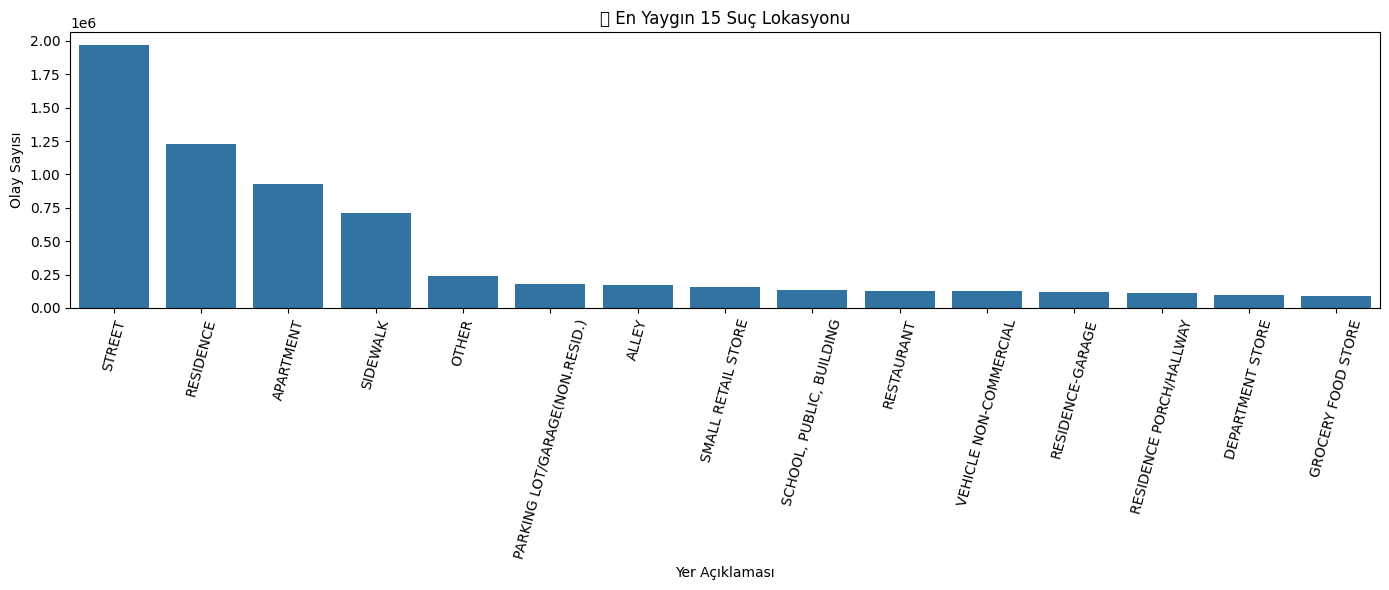

In [44]:
plt.figure(figsize=(14,6))
top_locations = df['Location Description'].value_counts().nlargest(15)
sns.barplot(x=top_locations.index, y=top_locations.values)
plt.xticks(rotation=75)
plt.title('📍 En Yaygın 15 Suç Lokasyonu')
plt.ylabel('Olay Sayısı')
plt.xlabel('Yer Açıklaması')
plt.tight_layout()
plt.show()

Bu çubuk grafik, veri setindeki suç olaylarının en sık meydana geldiği ilk 15 lokasyon açıklamasını ve bu lokasyonlardaki olay sayısını göstermektedir. Grafiğin x ekseni farklı lokasyon kategorilerini temsil ederken, y ekseni her bir lokasyonda kaydedilen olay sayısını ifade etmektedir. Grafiğe genel olarak bakıldığında, "STREET" suçların açık ara en yaygın olduğu yer olarak öne çıkmaktadır. Bu, suçların büyük bir kısmının kamusal açık alanlarda işlendiğini göstermektedir. "RESIDENCE" ve "APARTMENT" gibi yerleşim yerleri de yüksek olay sayılarına sahip olup, suçların önemli bir kısmının özel mülklerde de gerçekleştiğini ortaya koymaktadır. "SIDEWALK", "OTHER" ve "PARKING LOT/GARAGE(NON.RESID.)" gibi lokasyonlar da ilk 15 içinde yer almaktadır. Grafiğin sağ tarafına doğru ilerledikçe, "GROCERY FOOD STORE" gibi yerlerdeki olay sayılarının daha düşük olduğu görülmektedir. Bu dağılım, suçların coğrafi yoğunlaşmasını ve riskli bölgelerin belirlenmesi için önemli ipuçları sunmaktadır. Bu grafikteki bilgiler, suç önleme stratejilerini geliştirirken, özellikle cadde ve konut alanlarına odaklanmanın faydalı olabileceğini düşündürmektedir. Ayrıca, belirli lokasyonlardaki suç türleri arasındaki ilişkilerin incelenmesi, bölgesel güvenlik analizleri için de temel oluşturabilir.

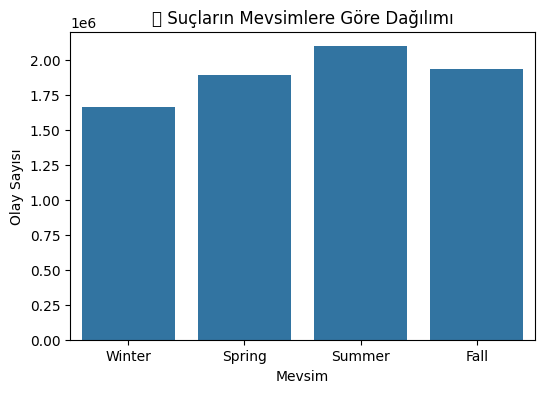

In [43]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Season_Original', order=['Winter', 'Spring', 'Summer', 'Fall'])
plt.title('🌦️ Suçların Mevsimlere Göre Dağılımı')
plt.ylabel('Olay Sayısı')
plt.xlabel('Mevsim')
plt.show()


Bu çubuk grafik, veri setindeki suç olaylarının mevsimlere göre dağılımını ve her bir mevsimdeki olay sayısını göstermektedir. Grafiğin x ekseni "Winter", "Spring", "Summer" ve "Fall" olmak üzere dört ana mevsimi, y ekseni ise ilgili mevsimde kaydedilen olay sayısını ifade etmektedir. Grafiğe bakıldığında, "Summer" mevsiminin en yüksek suç olay sayısına sahip olduğu açıkça görülmektedir. Bunu sırasıyla "Fall" ve "Spring" mevsimleri takip etmektedir. "Winter" mevsimi ise diğer mevsimlere göre en düşük suç olay sayısına sahiptir. Bu mevsimsel eğilim, sıcak hava koşullarının ve insanların daha fazla dışarıda bulunmasının suç oranlarını artırabileceği yönündeki yaygın gözlemlerle uyumlu görünmektedir. Özellikle hırsızlığın en yüksek suç türü olması ve en çok suç işlenen mevsimin yaz olması benim için aralarında bir ilişki olduğunu düşündürmektedir. Özellikle yaz aylarında artan sosyal aktivite ve dış mekan etkinlikleri, suçlar için daha fazla fırsat yaratabilir. Bu grafikteki bilgiler, kolluk kuvvetlerinin kaynaklarını mevsimlere göre tahsis etmesi veya belirli mevsimlerde suç önleme tedbirlerini artırması gibi stratejiler için önemli bir rehber olabilir.

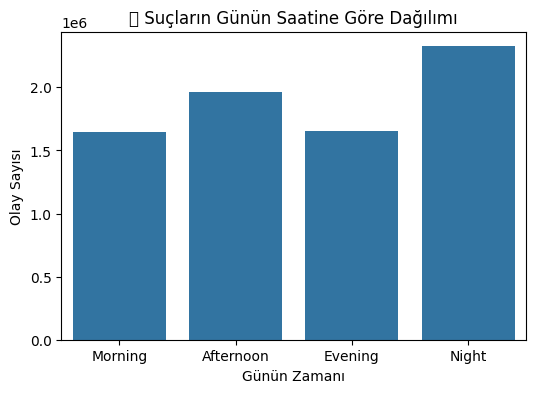

In [42]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='TimeOfDay_Original', order=['Morning', 'Afternoon', 'Evening', 'Night'])
plt.title('🕐 Suçların Günün Saatine Göre Dağılımı')
plt.ylabel('Olay Sayısı')
plt.xlabel('Günün Zamanı')
plt.show()


Bu çubuk grafik, veri setindeki suç olaylarının günün farklı saat dilimlerine göre dağılımını ve her bir dilimde kaydedilen olay sayısını göstermektedir. Grafiğin x ekseni "Morning", "Afternoon", "Evening" ve "Night" olmak üzere dört ana zaman dilimini, y ekseni ise ilgili zaman diliminde kaydedilen olay sayısını ifade etmektedir. Grafiğe bakıldığında, "Night" zaman diliminde suç olay sayısının en yüksek olduğu açıkça görülmektedir. Bunu sırasıyla "Afternoon" ve "Morning" takip etmektedir. "Evening" zaman dilimi ise diğer zaman dilimlerine göre daha düşük, ancak "Morning" ile benzer bir suç olay sayısına sahiptir. Bu zaman dilimsel eğilim, suçların özellikle gece saatlerinde daha yoğun yaşandığını ortaya koymaktadır. Gece saatlerinde düşük görüş mesafesi, daha az denetim ve artan alkol/madde kullanımı gibi faktörler suç oranlarının artmasına katkıda bulunabilir. Yine en çok işlenen suç türü olan hırsızlık ile gece suç işlenme sayısının fazla olması arasında da bir ilişki olabilir. Bu grafikteki bilgiler, kolluk kuvvetlerinin devriye güzergahlarını ve personel dağılımını günün farklı saatlerine göre optimize etmesi için önemli bir rehber olabilir. Örneğin, gece saatlerinde artırılmış güvenlik önlemleri veya belirli suç türlerine yönelik özel müdahaleler planlanabilir. Bu tür zaman bazlı analizler, suç önleme stratejilerini daha da kuvvetlendirebilir.

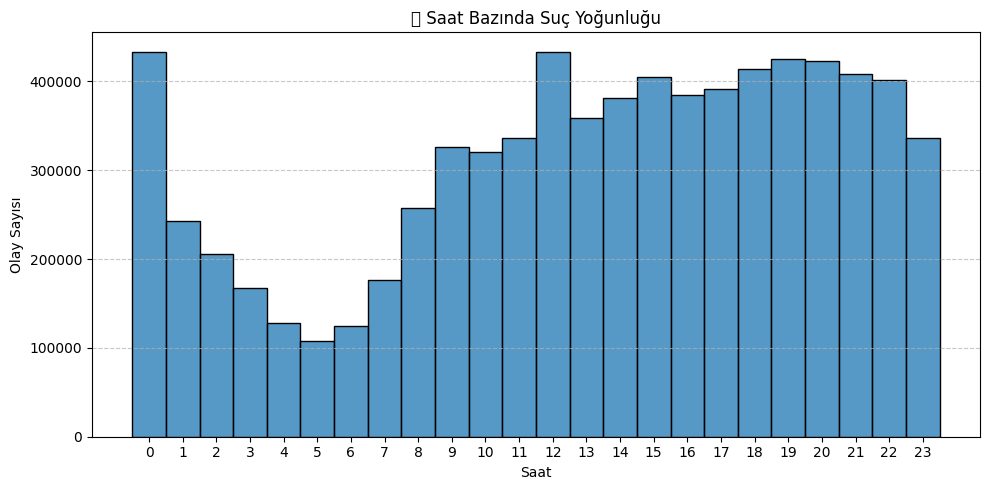

In [41]:
plt.figure(figsize=(10,5))
sns.histplot(data=df, x='Hour', bins=24, discrete=True)
plt.title('🕐 Saat Bazında Suç Yoğunluğu')
plt.xlabel('Saat')
plt.ylabel('Olay Sayısı')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Bu histogram, veri setindeki suç olaylarının 24 saatlik gün dilimine göre dağılımını ve her bir saat diliminde kaydedilen olay sayısını göstermektedir. Grafiğin x ekseni "Saat" (0'dan 23'e kadar), y ekseni ise "Olay Sayısı"nı ifade etmektedir. Grafiğe bakıldığında, suç olaylarının gün içinde belirli saatlerde yoğunlaştığı açıkça görülmektedir. Sabahın erken saatlerinde (0-1 arası) yüksek bir pik yaşanırken, ardından olay sayılarında belirgin bir düşüş gözlenmektedir. En düşük suç yoğunluğu sabah 4 ile 6 saatleri arasında görülmektedir. Gün ilerledikçe, özellikle 07:00'den itibaren olay sayılarında kademeli bir artış başlamakta ve öğle saatlerinde (12-13 arası) başka bir zirveye ulaşmaktadır. En yüksek suç yoğunluğu ise akşam ve gece saatlerinde, özellikle 17:00 ile 20:00 arasında belirgin bir artış göstererek devam etmektedir. Bu saatlik dağılım, insanların günlük rutinleri, işten dönüş saatleri, sosyal aktiviteler ve genel olarak dışarıda bulunma süreleri ile paralellik gösterebilir. Bu grafikteki bilgiler, kolluk kuvvetlerinin kaynaklarını günün en yoğun suç saatlerine odaklaması, belirli saatlerde devriye sayısını artırması veya suç türüne özel müdahaleleri zamanlaması için kritik bir rehber olabilir. Örneğin, akşam saatlerinde hırsızlık, gece saatlerinde ise belirli şiddet suçları artış gösterebilir. Bu tür detaylı zaman bazlı analizler, suç önleme stratejilerinin daha hedefli ve etkili olmasını sağlamaktadır.


Bir üstteki grafik olan Suçların Günün Saatine Göre Dağılımı grafiği ile bu grafik paralellik göstermektedir. Günü hangi kural setine göre böldüğümüzle ile ilgili kod aşağıda yer almaktadır.


def time_of_day(hour):

    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

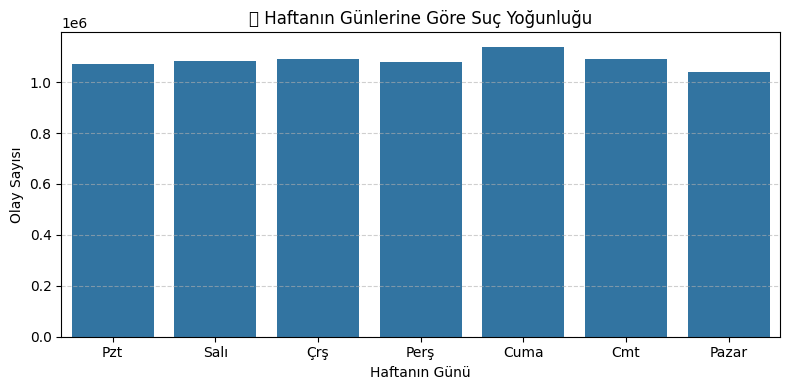

In [40]:
plt.figure(figsize=(8,4))
weekday_labels = ['Pzt', 'Salı', 'Çrş', 'Perş', 'Cuma', 'Cmt', 'Pazar']
sns.countplot(data=df, x='Weekday')
plt.title('📆 Haftanın Günlerine Göre Suç Yoğunluğu')
plt.xlabel('Haftanın Günü')
plt.ylabel('Olay Sayısı')
plt.xticks(ticks=range(7), labels=weekday_labels)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Bu çubuk grafik, veri setindeki suç olaylarının haftanın günlerine göre dağılımını ve her bir günde kaydedilen olay sayısını göstermektedir. Grafiğin x ekseni Pazartesi'den Pazar'a kadar haftanın günlerini, y ekseni ise ilgili günde kaydedilen olay sayısını ifade etmektedir. Grafiğe genel olarak bakıldığında, suç olay sayılarının hafta içinde nispeten dengeli bir dağılım sergilediği, ancak özellikle "Cuma" gününde hafif bir yükseliş olduğu dikkat çekmektedir. "Cumartesi" ve "Pazar" günleri de yüksek olay sayılarına sahipken, hafta başındaki "Pazartesi" ve "Salı" günleri ile "Çarşamba" ve "Perşembe" günleri birbirine yakın seviyelerde seyretmektedir. En düşük suç yoğunluğu "Pazar" günü kaydedilmiştir, ancak bu fark diğer günlere kıyasla çok belirgin değildir. Bu haftalık dağılım, insanların hafta sonu aktiviteleri, iş ve okul düzeni gibi faktörlerle ilişkilendirilebilir. Cuma günkü artış, hafta sonu başlangıcının getirdiği sosyal hareketlilikle açıklanabilirken, Pazar günündeki hafif düşüş, insanların genellikle evlerinde veya daha sakin bir ortamda bulunmalarıyla ilgili olabilir. Ancak genel olarak bakıldığında günler arasında anlamlı bir fark bulunmamaktadır.

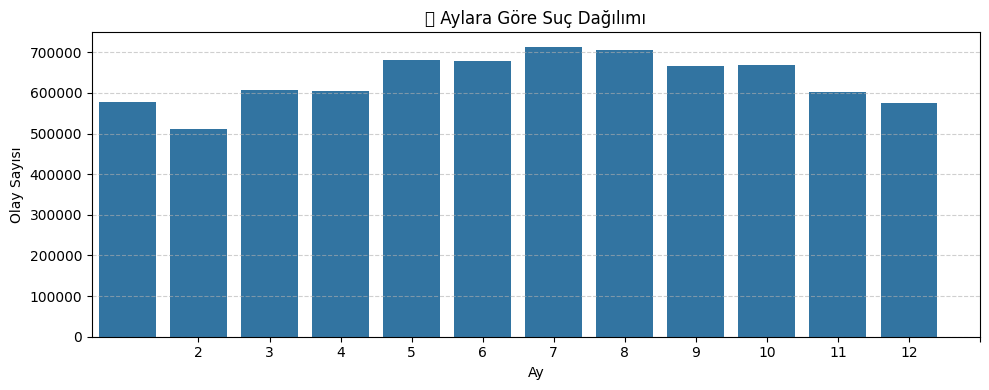

In [39]:
plt.figure(figsize=(10,4))
sns.countplot(data=df, x='Month')
plt.title('📅 Aylara Göre Suç Dağılımı')
plt.xlabel('Ay')
plt.ylabel('Olay Sayısı')
plt.xticks(range(1,13))
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Bu çubuk grafik, veri setindeki suç olaylarının yılın aylarına göre dağılımını ve her bir ayda kaydedilen olay sayısını göstermektedir. Grafiğin x ekseni 1'den 12'ye kadar ayları, y ekseni ise ilgili ayda kaydedilen olay sayısını ifade etmektedir. Grafiğe genel olarak bakıldığında, yılın ilk çeyreğinde suç olay sayılarının nispeten daha düşük olduğu, ancak ilkbahardan itibaren bir artış eğilimine girdiği gözlenmektedir. Özellikle yaz ayları olan "Mayıs", "Haziran", "Temmuz" ve "Ağustos" aylarında suç olay sayılarının zirve yaptığı açıkça görülmektedir. "Temmuz" ve "Ağustos" ayları, en yüksek suç yoğunluğuna sahip aylardır. Sonbahar aylarına doğru, olay sayılarında hafif bir düşüş başlarken, yıl sonuna doğru bu düşüşün devam ettiği anlaşılmaktadır. Bu aylık dağılım, daha önceki mevsimsel analizle de uyumlu olup, özellikle yaz aylarında artan dış mekan aktiviteleri, tatiller ve genel nüfus hareketliliği gibi faktörlerle ilişkilendirilebilir. Bu grafikteki bilgiler, kolluk kuvvetlerinin kaynaklarını yılın belirli aylarına göre yeniden düzenlemesi, yaz aylarında ek devriye veya önleyici tedbirler planlaması için kritik bir rehber olabilir. Ayrıca, belirli suç türlerinin hangi aylarda daha yoğun yaşandığını incelemek, daha hedefli önleme stratejileri geliştirmeye olanak tanıyabilir.

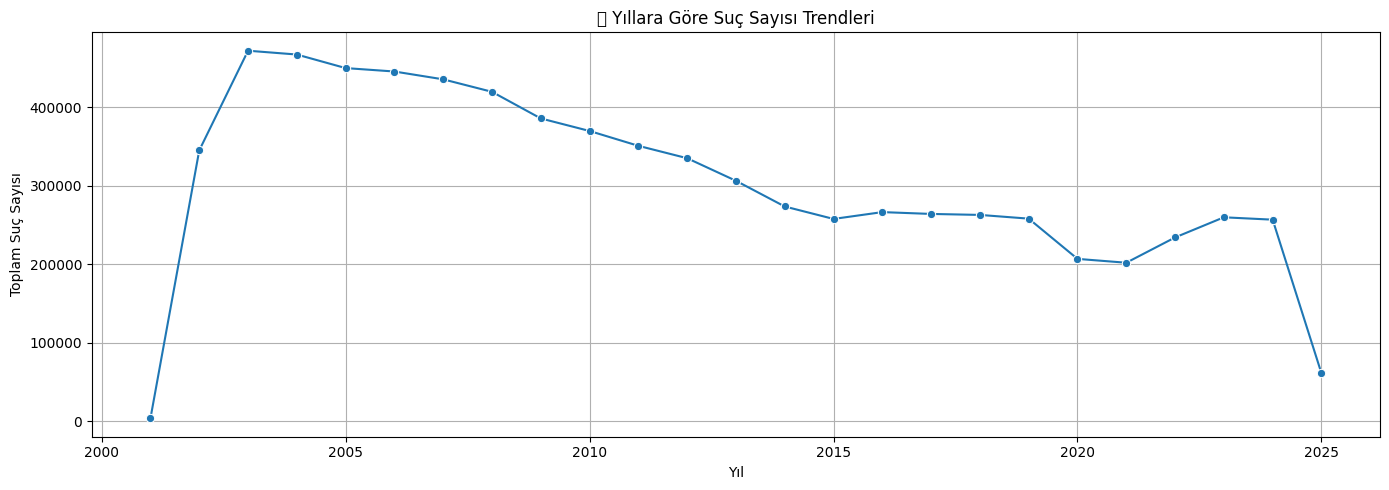

In [38]:
yearly_counts = df['Year'].value_counts().sort_index()

plt.figure(figsize=(14,5))
sns.lineplot(x=yearly_counts.index, y=yearly_counts.values, marker='o')
plt.title('📈 Yıllara Göre Suç Sayısı Trendleri')
plt.xlabel('Yıl')
plt.ylabel('Toplam Suç Sayısı')
plt.grid(True)
plt.tight_layout()
plt.show()


Bu çizgi grafiği, veri setindeki suç olaylarının 2000 yılından 2025 yılına kadar olan yıllık trendini ve her bir yılda kaydedilen toplam suç sayısını göstermektedir. Grafiğin x ekseni "Yıl"ı, y ekseni ise toplam suç sayısını ifade etmektedir.

Grafiğe genel olarak bakıldığında, suç sayılarında zaman içinde önemli dalgalanmalar olduğu gözlenmektedir:

* **2000-2003 Arası Yükseliş:** 2000 yılında çok düşük bir seviyeden başlayan suç olayları, 2003 yılına kadar keskin bir artış göstermiş ve 2003 yılında ilk zirvesine ulaşmıştır.
* **2003-2015 Arası Genel Düşüş Eğilimi:** 2003'teki zirveden sonra, 2015 yılına kadar genel olarak kademeli bir düşüş eğilimi gözlemlenmektedir. Bu dönemde zaman zaman küçük dalgalanmalar olsa da, yıllık suç sayısı düşüşünü sürdürmüştür.
* **2015-2019 Arası Benzer Değerler:** 2015 ile 2019 yılları arasında suç sayılarında nispeten daha stabil bir seyir izlenmiş, belirgin bir düşüş veya artış gözlenmemiştir.
* **2019-2020 Keskin Düşüş:** 2019'dan 2020'ye doğru suç sayılarında belirgin bir düşüş yaşanmıştır. Bu düşüşün küresel salgın ve uygulanan kısıtlamalar gibi faktörlerle ilişkili olma ihtimali yüksektir.
* **2020-2023 Arası Toparlanma ve Tekrar Düşüş:** 2020'deki düşüşün ardından 2023 yılına doğru suç sayılarında kısmi bir toparlanma ve ardından tekrar bir düşüş eğilimi görülmektedir.
* **2024 ve 2025 Verileri:** 2025 yılı verisi, muhtemelen tamamlanmamış veya kısmi bir yıl verisi olduğu için keskin bir düşüşle sonlanmaktadır. Benzer şekilde, 2024 verisi de daha önceki yıllara göre belirgin bir düşüş göstermektedir. Bu son yıllardaki düşüşler, güvenlik kuvvetlerinin teknolojik imkanlarının artması, güvenlik kuvvetleri niteliğinin artması, suçun caydırıcılığının artması ya da veri toplama döneminin bitişi veya henüz tamamlanmamış yıl verileri nedeniyle olabilir.

Bu grafikteki yıllık trend analizi, suç politikalarının etkilerini, sosyo-ekonomik değişimlerin suç oranlarına yansımalarını veya büyük ölçekli olayların suç üzerindeki etkilerini incelemek için önem taşıyabilir. Bu tür uzun dönemli trendler, gelecekteki suç projeksiyonları ve önleyici tedbirlerin planlanması için değerli bir temel oluşturur. Eksik veya tamamlanmamış son yıl verileri, bu yıllara ait yorumları daha dikkatli yapmamıza neden olmaktadır.

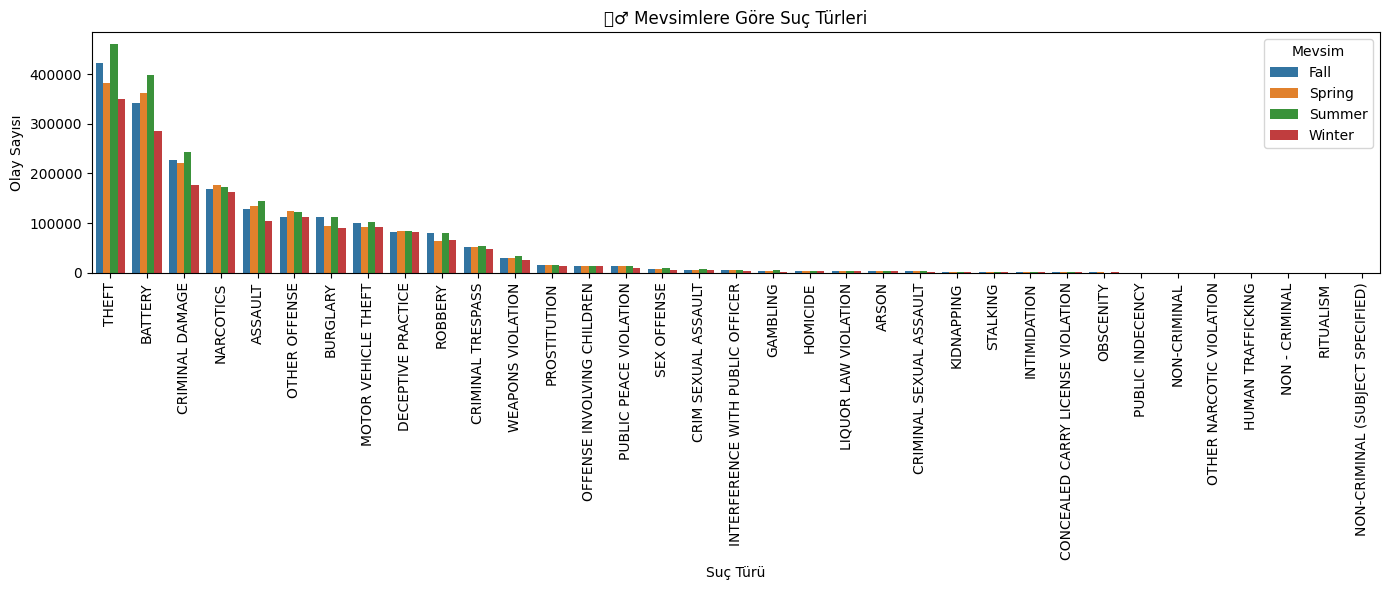

In [37]:
plt.figure(figsize=(14,6))
sns.countplot(data=df, x='PrimaryType_Original', hue='Season_Original',
              order=df['PrimaryType_Original'].value_counts().index)
plt.title('🕵️‍♂️ Mevsimlere Göre Suç Türleri')
plt.xticks(rotation=90)
plt.xlabel('Suç Türü')
plt.ylabel('Olay Sayısı')
plt.legend(title='Mevsim')
plt.tight_layout()
plt.show()


Bu gruplandırılmış çubuk grafik, veri setindeki her birincil suç türünün mevsimlere göre dağılımını ve her bir suç türünün her mevsimdeki olay sayısını göstermektedir. Grafiğin x ekseni farklı suç kategorilerini sıralarken, y ekseni olay sayısını ifade etmektedir. Her suç türü için dört farklı renkli çubuk ilgili mevsimdeki olay sayısını belirtmektedir.


* **Genel Eğilim:** Çoğu suç türünde, özellikle ilk 5-6 en yaygın suç türünde (THEFT, BATTERY, CRIMINAL DAMAGE vb.), Yaz mevsiminde olay sayısının diğer mevsimlere göre daha yüksek olduğu görülmektedir. Bu durum, önceki mevsimsel analizle de uyumlu olup, yaz aylarında artan insan hareketliliği ve dış mekan aktivitelerinin suç fırsatlarını artırdığını düşündürmektedir.
* **THEFT:** En yaygın suç türü olan hırsızlıkta, yaz aylarında belirgin bir artış gözlenmektedir. Sonbahar ve ilkbahar da yüksek seviyelerdeyken, kış aylarında hafif bir düşüş yaşanmaktadır.
* **BATTERY ve CRIMINAL DAMAGE:** Bu suç türleri de hırsızlık gibi yaz aylarında zirve yapma eğilimindedir.
* **NARCOTICS:** Narkotik suçlarında da yaz ve ilkbahar aylarında bir artış eğilimi varken, kış aylarında daha düşük seviyeler görülmektedir.
* **BURGLARY:** Bu tür hırsızlıklar, diğer bazı suçlar kadar keskin bir mevsimsel dalgalanma göstermese de, yine de yaz aylarında hafif bir yükseliş gözlenebilir.
* **Diğer Suç Türleri:** Daha az sıklıkta görülen suç türlerinde (örneğin HOMICIDE, ARSON, KIDNAPPING) mevsimsel örüntüler daha az belirgin olabilir veya örneklem boyutu nedeniyle net bir eğilim yakalamak zor olabilir.

Bu grafikteki ayrıntılı mevsimsel analiz, örneğin, yaz aylarında hırsızlık ve darp suçlarındaki artışa yönelik özel güvenlik önlemleri alınmasını sağlayabilir. Bu tür bilgiler, kolluk kuvvetlerinin kaynak tahsisini ve suçla mücadele yöntemlerini daha etkili bir şekilde planlamasına yardımcı olacaktır.

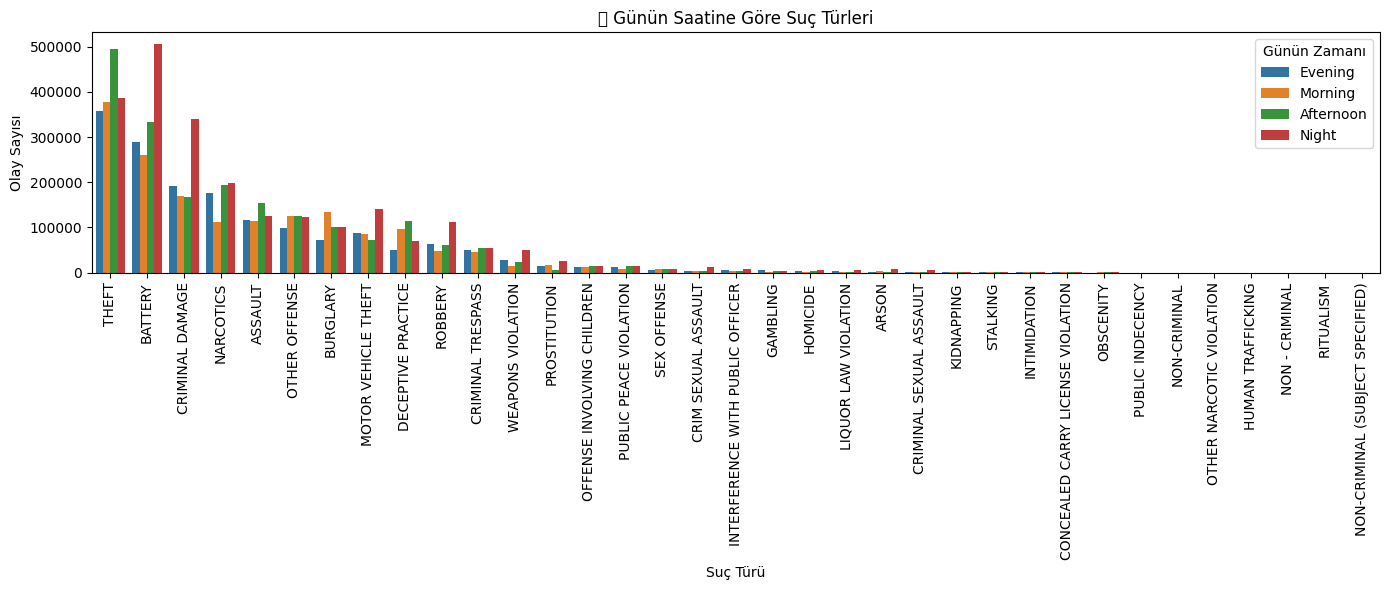

In [36]:
plt.figure(figsize=(14,6))
sns.countplot(data=df, x='PrimaryType_Original', hue='TimeOfDay_Original',
              order=df['PrimaryType_Original'].value_counts().index)
plt.title('⏰ Günün Saatine Göre Suç Türleri')
plt.xticks(rotation=90)
plt.xlabel('Suç Türü')
plt.ylabel('Olay Sayısı')
plt.legend(title='Günün Zamanı')
plt.tight_layout()
plt.show()


Bu gruplandırılmış çubuk grafik, veri setindeki her birincil suç türünün günün saat dilimlerine göre dağılımını ve her bir suç türünün her saat dilimindeki olay sayısını göstermektedir. Grafiğin x ekseni farklı suç kategorilerini sıralarken, y ekseni olay sayısını ifade etmektedir. Her suç türü için dört farklı renkli çubuk ilgili saat dilimindeki olay sayısını belirtmektedir.

* **Genel Eğilim:** Çoğu suç türünde, özellikle en yaygın suç türlerinde ("THEFT", "BATTERY", "CRIMINAL DAMAGE"), "Night" saatlerinde olay sayısının diğer zaman dilimlerine göre daha yüksek olduğu açıkça görülmektedir. Bu durum, daha önceki günün saatine göre suç dağılımı analiziyle de uyumlu olup, gece saatlerinde suç fırsatlarının arttığını düşündürmektedir.
* **THEFT:** En yaygın suç türü olan hırsızlıkta, gece saatlerinde belirgin bir artış gözlenmektedir. Akşam ve öğleden sonra saatleri de yüksek seviyelerdeyken, sabah saatlerinde daha düşük olay sayıları bulunmaktadır.
* **BATTERY:** Darp suçlarında da gece saatleri zirve yaparken, akşam ve öğleden sonra saatleri de yüksek seviyelerdedir.
* **CRIMINAL DAMAGE:** Bu suç türünde de gece saatlerinde belirgin bir artış görülmektedir.
* **NARCOTICS ve ASSAULT:** Bu suç türlerinde de gece saatleri, diğer zaman dilimlerine göre daha yüksek olay sayılarına sahiptir.
* **MOTOR VEHICLE THEFT:** Gece saatlerinde bu suç türünde de bir artış eğilimi mevcuttur.
* **Diğer Suç Türleri:** Daha az sıklıkta görülen suç türlerinde (örneğin "HOMICIDE", "ARSON", "KIDNAPPING") de genellikle gece veya akşam saatlerinde bir miktar artış gözlemlenmektedir, ancak örneklem boyutu nedeniyle bu eğilimler daha az belirgin olabilir.

Bu grafikteki ayrıntılı günün saatine göre analiz, belirli suç türleri için hedefe yönelik önleme stratejileri geliştirmeye olanak tanır. Örneğin, gece saatlerinde hırsızlık ve darp suçlarındaki artışa yönelik özel devriye veya güvenlik önlemleri alınabilir. Bu tür bilgiler, kolluk kuvvetlerinin kaynak tahsisini ve suçla mücadele yöntemlerini günün farklı saatlerine göre daha etkili bir şekilde planlamasına yardımcı olacaktır.

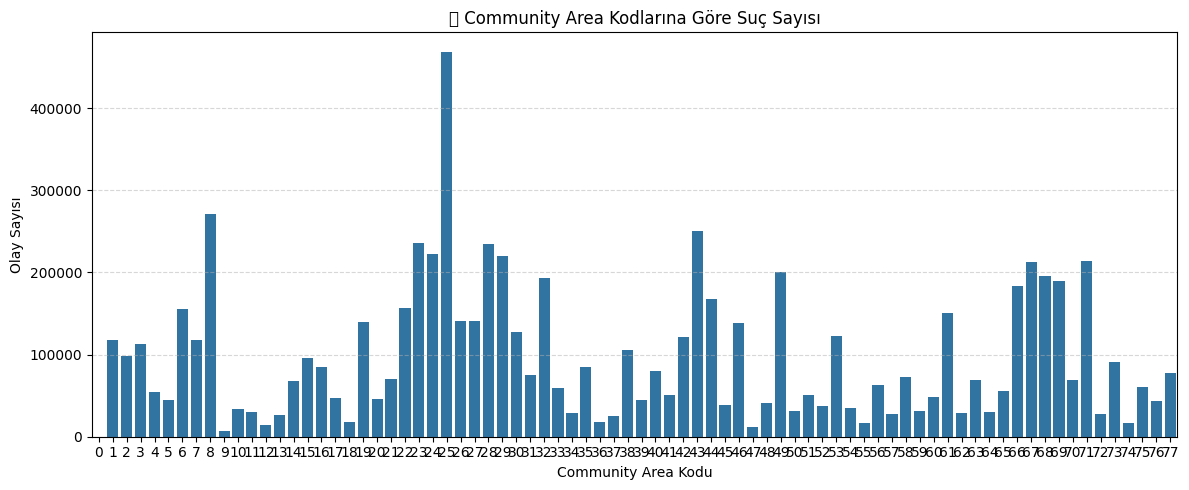

In [35]:
plt.figure(figsize=(12,5))
sns.countplot(data=df, x='CommunityArea_Code', order=sorted(df['CommunityArea_Code'].unique()))
plt.title('🗺️ Community Area Kodlarına Göre Suç Sayısı')
plt.xlabel('Community Area Kodu')
plt.ylabel('Olay Sayısı')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Bu çubuk grafik, veri setindeki suç olaylarının farklı Topluluk Bölgesi Kodlarına ("Community Area Kodu") göre dağılımını ve her bir bölgede kaydedilen olay sayısını ("Olay Sayısı") göstermektedir. Grafiğin x ekseni 0'dan 77'ye kadar uzanan çeşitli topluluk bölgesi kodlarını, y ekseni ise ilgili bölgedeki olay sayısını ifade etmektedir.

Grafiğe genel olarak bakıldığında, suç sayılarının topluluk bölgeleri arasında oldukça heterojen bir dağılım sergilediği açıkça görülmektedir. Bazı bölgelerde suç yoğunluğu oldukça yüksekken, bazılarında ise belirgin şekilde düşüktür.

**Öne Çıkan Gözlemler:**

* **Yüksek Yoğunluklu Bölgeler:** Özellikle "25" numaralı Topluluk Bölgesi'nde (muhtemelen West Side, Austin veya Humboldt Park gibi bir bölgeye karşılık gelir) suç olay sayısının diğer tüm bölgelere göre açık ara en yüksek olduğu görülmektedir. Bu bölge, 450.000'e yakın olay sayısıyla dikkat çekmektedir.
* **Diğer Yüksek Bölgeler:** "8", "23", "24", "49", "67", "68" ve "77" gibi bazı diğer bölgelerde de nispeten yüksek suç sayıları gözlenmektedir. Bu bölgeler, büyük olasılıkla kentsel alanlardaki yoğun nüfuslu veya belirli sosyal/ekonomik zorluklar yaşayan bölgeleri temsil edebilir.
* **Düşük Yoğunluklu Bölgeler:** Grafikte, suç olay sayısının oldukça düşük olduğu birçok bölge de bulunmaktadır. Örneğin, 0-20 arasındaki bazı bölgeler, 20-30 arasındaki bölgeler ve 50'lerden sonraki bazı bölgeler daha az suçla ilişkilendirilmektedir. Bu bölgeler genellikle daha seyrek nüfuslu, banliyö veya daha güvenli olarak bilinen alanlar olabilir.
* **Düzensiz Dağılım:** Suç sayılarının bölgeden bölgeye büyük farklılıklar göstermesi, suçların coğrafi olarak yoğunlaştığını ve belirli kentsel alanlarda daha büyük bir sorun teşkil ettiğini göstermektedir.

Bu grafik, suçla mücadele ve önleme stratejilerini coğrafi olarak hedeflemeye olanak tanır. Yüksek suç oranına sahip bölgelere (örneğin 25 numaralı bölge) daha fazla kolluk kuvveti kaynağı tahsis edilebilir, sosyal programlar yoğunlaştırılabilir veya bölgeye özgü sorunlara yönelik çözümler geliştirilebilir. Bu tür bölgesel analizler, sınırlı kaynakların en etkili şekilde kullanılmasına yardımcı olur ve topluluk bazlı güvenlik girişimlerinin planlanması için temel oluşturur.

In [ ]:
import folium
from folium.plugins import HeatMap

map_center = [41.8781, -87.6298]
crime_map = folium.Map(location=map_center, zoom_start=11)

heat_data = df[['Latitude', 'Longitude']].dropna().values.tolist()

HeatMap(heat_data, radius=10).add_to(crime_map)

crime_map


Bu ısı haritası, suç olaylarının coğrafi yoğunluğunu Chicago şehri üzerinde görselleştirmektedir. Harita, enlem ve boylam koordinatları kullanılarak oluşturulmuş olup, belirli bölgelerdeki suç yoğunluğunu renk tonları ile ifade etmektedir.

**Görselleştirmeden Çıkarılan Temel Gözlemler:**

* **Yoğun Suç Bölgeleri (Sıcak Noktalar):** Haritada açık yeşilden sarıya ve hatta kırmızıya doğru değişen renkler, suç olaylarının en yoğun olduğu alanları göstermektedir. Özellikle Chicago'nun doğu kesiminde, Michigan Gölü kıyısına yakın bölgelerde (muhtemelen şehir merkezi ve çevresi) çok belirgin "sıcak noktalar" (koyu yeşil/sarı alanlar) bulunmaktadır. Bu, şehir merkezinin ve civardaki yoğun bölgelerin suç oranları açısından daha riskli olduğunu düşündürmektedir.
* **Orta Yoğunluklu Bölgeler:** Sıcak noktaların etrafında ve şehir içinde daha geniş alanlarda açık yeşil tonları görülmektedir. Bu bölgeler, sıcak noktalara göre daha az yoğun olmakla birlikte, yine de düzenli olarak suç olaylarının meydana geldiği alanlardır.
* **Düşük Yoğunluklu Bölgeler:** Haritanın batı ve kuzeybatı kısımlarında, renk tonları daha soluktur veya hiç renk bulunmamaktadır. Bu alanlar, suç olaylarının çok daha az meydana geldiği veya hiç kaydedilmediği bölgelerdir.
* **Kentsel Dağılım:** Isı haritası, suçların kentsel alanda eşit bir şekilde dağılmadığını, aksine belirli bölgelerde yoğunlaştığını açıkça göstermektedir. Bu yoğunlaşma, muhtemelen nüfus yoğunluğu, ekonomik durum, sosyal altyapı ve kolluk kuvvetlerinin mevcudiyeti gibi faktörlerle ilişkilidir.
* **Ulaşım Ağları ve Suç:** Haritadaki yeşil/sarı alanlar, genellikle ana yolların ve kentsel ulaşım ağlarının geçtiği bölgelerle çakışmaktadır. Bu durum, suçların ulaşım erişilebilirliği yüksek ve insan hareketliliğinin fazla olduğu yerlerde daha sık meydana geldiğini düşündürebilir.

Bu grafikteki gibi bu tür bir ısı haritası, suçla mücadele stratejilerini coğrafi olarak programlamak için son derece değerli bir araçtır. Kolluk kuvvetleri, kaynaklarını bu sıcak noktalara odaklayarak devriye sayısını artırabilir, belirli suç türlerine yönelik özel operasyonlar düzenleyebilir veya topluluk katılım programlarını bu bölgelerde yoğunlaştırabilir. Ayrıca, şehir planlamacılar ve sosyal hizmet sağlayıcılar da bu bilgiyi kullanarak, suçun temelindeki sosyo-ekonomik nedenleri ele almaya yönelik programlar geliştirebilirler.

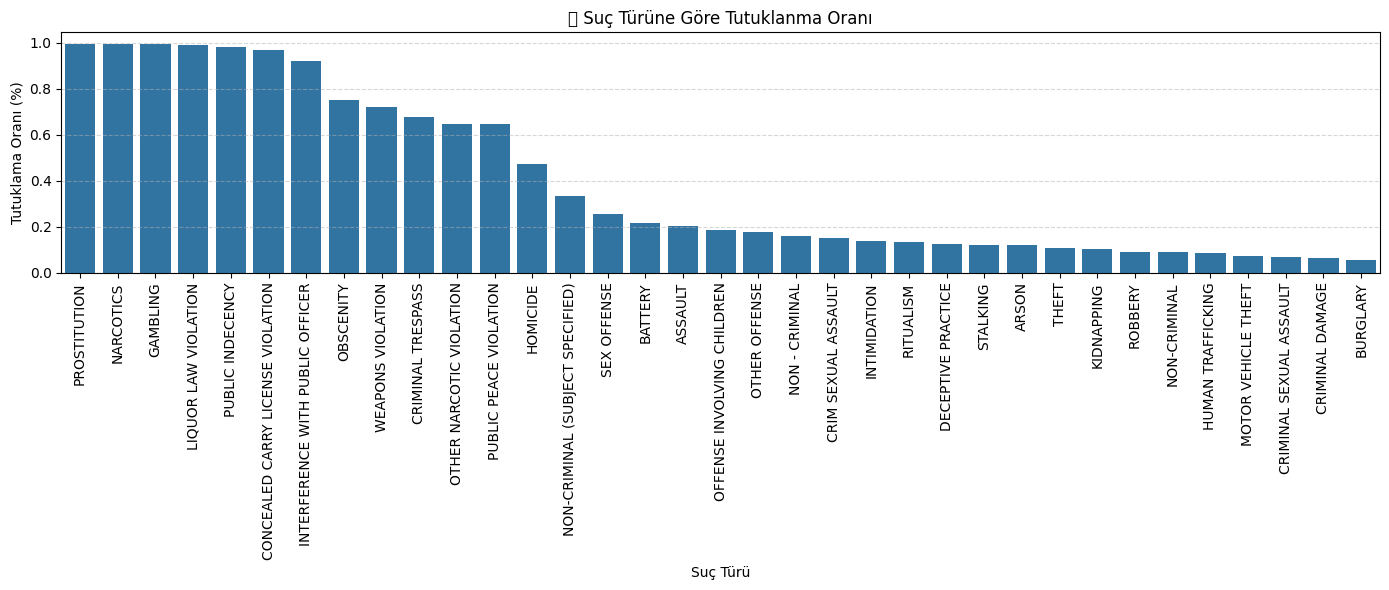

In [49]:
plt.figure(figsize=(14,6))
arrest_rates = df.groupby('PrimaryType_Original')['Arrest'].mean().sort_values(ascending=False)

sns.barplot(x=arrest_rates.index, y=arrest_rates.values)
plt.xticks(rotation=90)
plt.title('🔒 Suç Türüne Göre Tutuklanma Oranı')
plt.ylabel('Tutuklama Oranı (%)')
plt.xlabel('Suç Türü')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Bu çubuk grafik, veri setindeki her birincil suç türünün tutuklanma oranlarını göstermektedir. Grafiğin x ekseni farklı suç kategorilerini azalan tutuklanma oranına göre sıralarken, y ekseni tutuklanma oranını yüzde olarak ifade etmektedir.

Grafiğe genel olarak bakıldığında, farklı suç türleri arasında tutuklanma oranları açısından belirgin farklılıklar olduğu gözlenmektedir:

* **Yüksek Tutuklanma Oranına Sahip Suçlar:** Grafiğin sol tarafında yer alan "PROSTITUTION", "NARCOTICS", "GAMBLING", "LIQUOR LAW VIOLATION" ve "CONCEALED CARRY LICENSE VIOLATION" gibi suç türleri, %90'ın üzerinde oldukça yüksek tutuklanma oranlarına sahiptir. Bu tür suçlar genellikle olay anında veya kısa sürede faillerin tespit edilip yakalanmasının daha kolay olduğu veya kolluk kuvvetlerinin bu suçlara daha fazla odaklandığı türler olabilir.
* **Orta Seviye Tutuklanma Oranına Sahip Suçlar:** "PUBLIC INDECENCY", "OBSCENITY", "WEAPONS VIOLATION" gibi suçlar orta seviyede tutuklanma oranlarına sahiptir.
* **Düşük Tutuklanma Oranına Sahip Suçlar:** Grafiğin sağ tarafında yer alan "THEFT", "MOTOR VEHICLE THEFT", "ROBBERY", "CRIMINAL DAMAGE" ve özellikle "BURGLARY" gibi suç türleri, %20'nin altında, hatta bazıları %10'un altında oldukça düşük tutuklanma oranlarına sahiptir. Bu tür suçlar genellikle olay yerinde failin bulunmasının zor olduğu, kanıt toplamanın daha güç olduğu veya faillerin hızlıca olay yerinden uzaklaşabildiği suçlar olabilir.

Bu grafikteki bilgiler, kolluk kuvvetlerinin hangi suç türlerinde daha başarılı olduğunu veya hangi alanlarda iyileştirmeye ihtiyaç duyduğunu anlamak için kritik önem taşır. Yüksek tutuklanma oranlarına sahip suçlar, genellikle daha görünür veya daha kolay tespit edilebilir suçlar iken, düşük oranlara sahip suçlar daha karmaşık soruşturma gerektirebilir veya daha az kanıt bırakabilir. Bu analiz, suç türüne özel soruşturma tekniklerinin geliştirilmesi, kaynak tahsisinin optimize edilmesi ve belirli suçlara yönelik önleyici tedbirlerin gözden geçirilmesi için bir temel oluşturur.

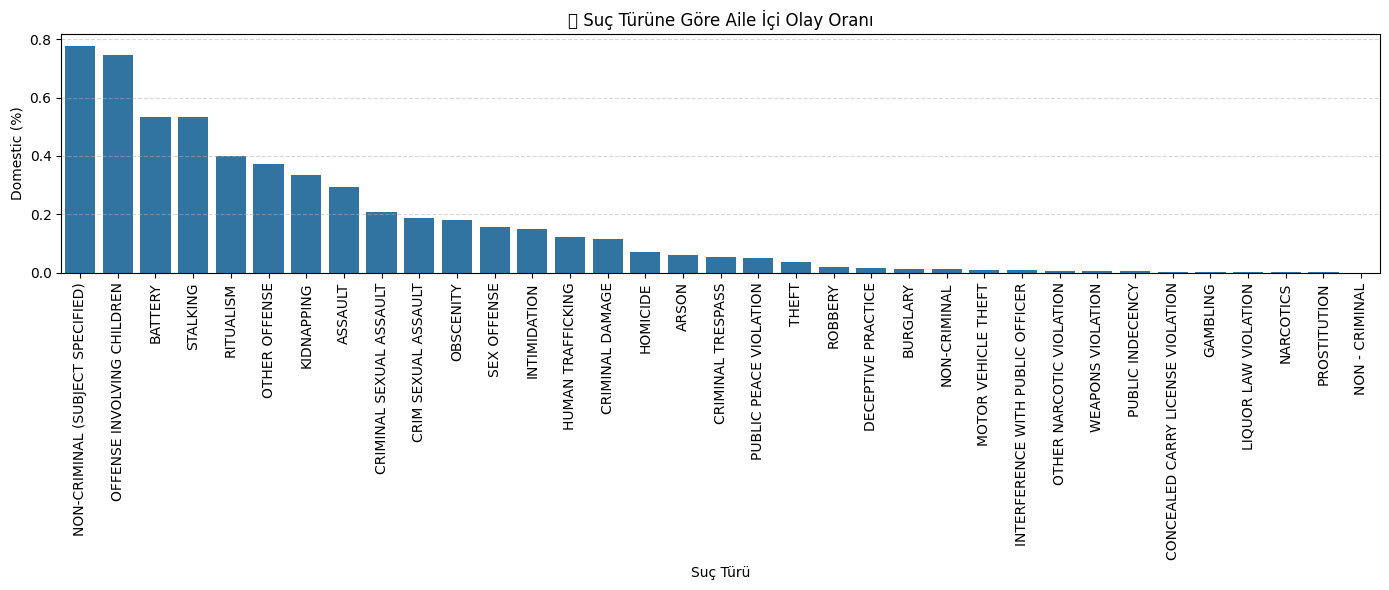

In [50]:
plt.figure(figsize=(14,6))
domestic_rates = df.groupby('PrimaryType_Original')['Domestic_Original'].mean().sort_values(ascending=False)

sns.barplot(x=domestic_rates.index, y=domestic_rates.values)
plt.xticks(rotation=90)
plt.title('🏠 Suç Türüne Göre Aile İçi Olay Oranı')
plt.ylabel('Domestic (%)')
plt.xlabel('Suç Türü')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Bu çubuk grafik, veri setindeki her birincil suç türünün aile içi olay olma oranını göstermektedir. Grafiğin x ekseni farklı suç kategorilerini azalan aile içi olay oranına göre sıralarken, y ekseni oranı yüzde olarak ifade etmektedir.

Grafiğe genel olarak bakıldığında, farklı suç türleri arasında aile içi olay olma oranları açısından belirgin farklılıklar olduğu gözlenmektedir:

* **Yüksek Aile İçi Olay Oranına Sahip Suçlar:** Grafiğin sol tarafında yer alan "NON-CRIMINAL (SUBJECT SPECIFIED)", "OFFENSE INVOLVING CHILDREN" ve "BATTERY" gibi suç türleri oldukça yüksek aile içi olay oranlarına sahiptir. Özellikle "NON-CRIMINAL (SUBJECT SPECIFIED)" ve "OFFENSE INVOLVING CHILDREN" suçları, %60'ın üzerinde bir oranla aile içi olay niteliği taşımaktadır. Bu durum, bu tür olayların büyük ölçüde aile içinde veya yakın ilişkilerde meydana geldiğini göstermektedir.
* **Orta Seviye Aile İçi Olay Oranına Sahip Suçlar:** "STALKING", "RITUALISM", "KIDNAPPING" ve "ASSAULT" gibi suçlar orta seviyede aile içi olay oranlarına sahiptir.
* **Düşük Aile İçi Olay Oranına Sahip Suçlar:** Grafiğin sağ tarafına doğru ilerledikçe, "THEFT", "ROBBERY", "BURGLARY", "MOTOR VEHICLE THEFT", "NARCOTICS", "GAMBLING" ve "CONCEALED CARRY LICENSE VIOLATION" gibi suç türlerinin aile içi olay olma oranlarının oldukça düşük, hatta sıfıra yakın olduğu görülmektedir. Bu, bu suçların genellikle aile dışı ortamlarda veya yabancılar arasında işlendiğini göstermektedir.

Bu grafikteki bilgiler, aile içi suçlara yönelik politikaların ve destek hizmetlerinin hangi suç türlerine odaklanması gerektiğini anlamak için kritik önem taşır. Özellikle "Çocukları Kapsayan Suçlar" ve "Darp" gibi yüksek orana sahip suçlarda, aile içi şiddetle mücadele programlarının veya çocuk koruma hizmetlerinin güçlendirilmesi gerekebilir. Düşük orana sahip suç türlerinde ise genel suç önleme stratejileri daha uygun olacaktır. Bu analiz, sınırlı kaynakların en etkili şekilde kullanılmasına ve belirli sorun alanlarına daha hedefe yönelik müdahalelerin geliştirilmesine yardımcı olur.

In [ ]:
def evaluate_model(model, X, y, cv_folds=5, model_name="Model"):
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, average='binary', zero_division=0),
        'recall': make_scorer(recall_score, average='binary', zero_division=0),
        'f1': make_scorer(f1_score, average='binary', zero_division=0),
        'roc_auc': make_scorer(roc_auc_score, needs_proba=True)
    }

    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    print(f"\n--- 🧪 {name} - Değerlendirme Başlıyor ---")
    start_total = time.time()

    print(f"[{name}] Cross-validation başlıyor...")
    start_cv = time.time()
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=False, n_jobs=1)
    end_cv = time.time()
    print(f"[{name}] Cross-validation tamamlandı. Süre: {end_cv - start_cv:.2f} saniye")

    print(f"[{name}] Tahminler alınıyor (cross_val_predict)...")
    start_predict = time.time()
    y_pred = cross_val_predict(model, X, y, cv=cv, n_jobs=1)
    end_predict = time.time()
    print(f"[{name}] Tahminler alındı. Süre: {end_predict - start_predict:.2f} saniye")

    cm = confusion_matrix(y, y_pred)
    clf_report = classification_report(y, y_pred, output_dict=True, zero_division=0)
    clf_df = pd.DataFrame(clf_report).transpose()

    duration = time.time() - start_total

    result = {
        'Model': model_name,
        'Accuracy': np.mean(scores['test_accuracy']),
        'Precision': np.mean(scores['test_precision']),
        'Recall': np.mean(scores['test_recall']),
        'F1 Score': np.mean(scores['test_f1']),
        'ROC AUC': np.mean(scores['test_roc_auc']),
        'Time (sec)': duration,
        'Confusion Matrix': cm,
        'Classification Report': clf_df
    }
    return result

In [ ]:
y = df['Arrest']
drop_cols = ['Arrest', 'PrimaryType_Original', 'PrimaryType_encoded', 'Season_Original', 'TimeOfDay_Original',
             'Domestic_Original', 'IsWeekend_Original', 'Location Description',
             'Date', 'Block', 'Description', 'FBI Code', 'IUCR', 'Community Area', 'Year', 'Month', 'Day', 'Hour', 'Weekday']
X = df.drop(columns=drop_cols)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_array = y.values


--- 🧪 Logistic Regression - Değerlendirme Başlıyor ---
[Logistic Regression] Cross-validation başlıyor...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/inspect.py", line 3195, in bind
    return self._bind(args, kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/inspect.

[Logistic Regression] Cross-validation tamamlandı. Süre: 152.15 saniye
[Logistic Regression] Tahminler alınıyor (cross_val_predict)...
[Logistic Regression] Tahminler alındı. Süre: 150.37 saniye

--- 🧾 Confusion Matrix - Logistic Regression: ---
[[5286148  400729]
 [ 743502 1160601]]

--- 📋 Classification Report - Logistic Regression: ---


,precision,recall,f1-score,support
0,0.876692,0.929534,0.902340,5.686877e+06
1,0.743341,0.609526,0.669816,1.904103e+06
accuracy,0.849264,0.849264,0.849264,8.492644e-01
macro avg,0.810017,0.769530,0.786078,7.590980e+06
weighted avg,0.843243,0.849264,0.844015,7.590980e+06


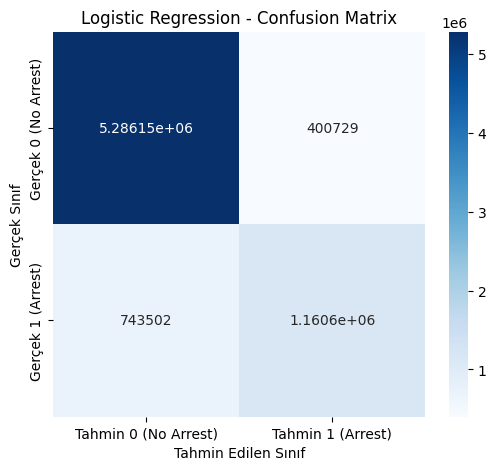


--- 🧪 Random Forest - Değerlendirme Başlıyor ---
[Random Forest] Cross-validation başlıyor...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/inspect.py", line 3195, in bind
    return self._bind(args, kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/inspect.

[Random Forest] Cross-validation tamamlandı. Süre: 12365.83 saniye
[Random Forest] Tahminler alınıyor (cross_val_predict)...
[Random Forest] Tahminler alındı. Süre: 12954.18 saniye

--- 🧾 Confusion Matrix - Random Forest: ---
[[5397837  289040]
 [ 633119 1270984]]

--- 📋 Classification Report - Random Forest: ---


,precision,recall,f1-score,support
0,0.895022,0.949174,0.921303,5.686877e+06
1,0.814721,0.667498,0.733798,1.904103e+06
accuracy,0.878519,0.878519,0.878519,8.785191e-01
macro avg,0.854871,0.808336,0.827550,7.590980e+06
weighted avg,0.874879,0.878519,0.874270,7.590980e+06


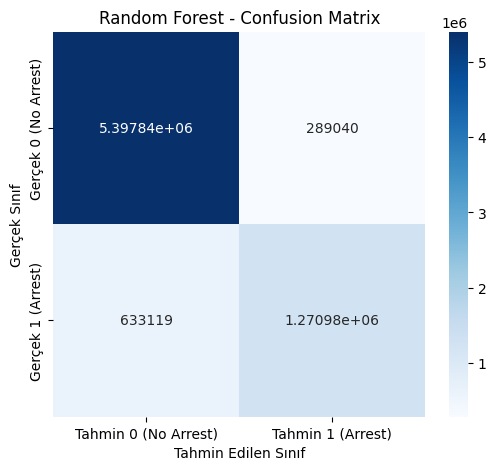


--- 🧪 XGBoost - Değerlendirme Başlıyor ---
[XGBoost] Cross-validation başlıyor...
[XGBoost] Cross-validation tamamlandı. Süre: 520.73 saniye
[XGBoost] Tahminler alınıyor (cross_val_predict)...
[XGBoost] Tahminler alındı. Süre: 490.51 saniye

--- 🧾 Confusion Matrix - XGBoost: ---
[[5561645  125232]
 [ 702660 1201443]]

--- 📋 Classification Report - XGBoost: ---


,precision,recall,f1-score,support
0,0.887831,0.977979,0.930727,5.686877e+06
1,0.905605,0.630976,0.743748,1.904103e+06
accuracy,0.890937,0.890937,0.890937,8.909374e-01
macro avg,0.896718,0.804477,0.837238,7.590980e+06
weighted avg,0.892289,0.890937,0.883826,7.590980e+06


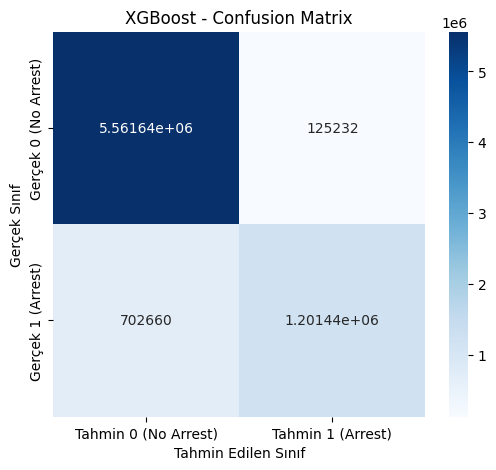


--- 📊 Değerlendirme Sonuçları ---
                 Model  Accuracy  Precision    Recall  F1 Score  ROC AUC  \
2              XGBoost  0.890937   0.905605  0.630976  0.743748      NaN   
1        Random Forest  0.878519   0.814721  0.667498  0.733798      NaN   
0  Logistic Regression  0.849264   0.743343  0.609526  0.669815      NaN   

     Time (sec)  
2   1012.196467  
1  25321.095883  
0    304.257742  


In [ ]:
logreg = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced', n_jobs=1)
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=1)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=1)

models = [
    (logreg, "Logistic Regression"),
    (rf, "Random Forest"),
    (xgb, "XGBoost")
]

results = []
for model, name in models:
    res = evaluate_model(model, X_scaled, y_array, model_name=name)

    print(f"\n--- 🧾 Confusion Matrix - {name}: ---")
    print(res['Confusion Matrix'])

    print(f"\n--- 📋 Classification Report - {name}: ---")
    display(res['Classification Report'])

    plt.figure(figsize=(6, 5))
    sns.heatmap(res['Confusion Matrix'], annot=True, fmt='g', cmap='Blues',
                xticklabels=['Tahmin 0 (No Arrest)', 'Tahmin 1 (Arrest)'],
                yticklabels=['Gerçek 0 (No Arrest)', 'Gerçek 1 (Arrest)'])
    plt.xlabel('Tahmin Edilen Sınıf')
    plt.ylabel('Gerçek Sınıf')
    plt.title(f'{name} - Confusion Matrix')
    plt.show()

    results.append({k: v for k, v in res.items() if k not in ['Confusion Matrix', 'Classification Report']})

results_df = pd.DataFrame(results)
print("\n--- 📊 Değerlendirme Sonuçları ---")
print(results_df.sort_values(by='F1 Score', ascending=False))

Bu projede, Chicago Suç Verisi üzerinden gerçekleştirilen olayların tutuklamayla sonuçlanıp sonuçlanmadığını tahmin etmeye çalıştım. Problemi ikili sınıflandırma problemi olarak tanımladım çünkü hedef değişkenim olan Arrest sütunu yalnızca iki olasılık içeriyordu: 1 (tutuklandı) ve 0 (tutuklanmadı). Bu tahminleme görevinde asıl amacım, elimdeki yapısal ve kategorik verilere dayalı olarak, bir olayın tutuklamaya dönüşüp dönüşmeyeceğini ne derece iyi öngörebileceğimi görmekti. Modelleme sürecine geçmeden önce detaylı bir veri ön işleme adımı uyguladım ve özellikle sınıf dengesizliğini göz önünde bulundurarak modelleri uygun şekilde yapılandırdım.

Veri ön işlemeye başlarken ilk iş olarak hedef değişken olan Arrest sütununu X’ten ayırdım. Bunun dışında modelin öğrenmesini istemediğim, doğrudan tahminleme üzerinde anlamlı etkisi olmayan ya da metin, tarih gibi doğrudan sayısallaştırılmamış özellikleri drop_cols listesiyle dışarıda bıraktım. Örneğin, “PrimaryType_Original” ya da “TimeOfDay_Original” gibi kategorik bilgilerin zaten encoding yapılmış halleri kullanılmakta olduğundan, bu sütunları modele doğrudan vermek yerine dönüştürülmüş hallerinden faydalandım. Ayrıca Date, Block, IUCR, FBI Code, Description gibi hem yüksek kardinaliteli hem de anlamlı bilgi üretme potansiyeli sınırlı olan sütunları da çıkardım. Bazı tarih özelliklerinin yıl, ay, gün gibi türetilmiş versiyonlarını da EDA aşamasında yeterince ayırt edici olmadıklarını gözlemlediğim için modele dahil etmedim.

Bu ön işlemlerin ardından elde edilen sayısal özellikleri StandardScaler kullanarak ölçekledim. Özellikle Logistic Regression gibi optimizasyon tabanlı, lineer modellerin büyük değerli özellikler karşısında küçük değerli özellikleri göz ardı edebilmesi söz konusu olduğundan bu adım kritik önem taşıyordu. Böylece tüm özelliklerin benzer ölçekte yer almasını ve modelin daha stabil öğrenmesini sağladım.

Modelleme sürecinde Logistic Regression, Random Forest ve XGBoost modellerini karşılaştırmalı olarak ele aldım. Bu üç modelin her birini 5-fold stratified cross-validation kullanarak değerlendirdim. Stratified K-Fold kullanmamın temel nedeni, veri setinde ciddi bir sınıf dengesizliği bulunmasıydı. Tutuklanma oranı oldukça düşük olduğundan, her katlamada pozitif ve negatif sınıfların oransal dağılımının korunması modelin daha tutarlı sonuçlar vermesini sağladı. Değerlendirmede accuracy’nin yanı sıra precision, recall ve F1 score metriklerini dikkate aldım. Özellikle F1 score, precision ve recall arasındaki dengeyi yansıttığı için bu projede en anlamlı karşılaştırma ölçütlerinden biri oldu.

Modellerin performansına bakıldığında en yüksek F1 skorunu 0.7437 ile XGBoost elde etti. Bu model aynı zamanda 0.9056 gibi çok yüksek bir precision değerine ulaştı. Yani XGBoost bir olay için “tutuklama var” dediğinde, bu tahminin %90’ından fazlası doğru çıkıyor. Bu durum modelin çok az yanlış pozitif (false positive) ürettiğini gösteriyor. Diğer yandan recall değeri 0.631 civarında kaldı, bu da modelin tüm gerçek tutuklamaların yalnızca %63’ünü yakalayabildiğini ortaya koyuyor. Yani bazı gerçek tutuklamaları kaçırıyor (false negative), ama bunu precision’ı yüksek tutmak uğruna yapıyor. Eğitim süresi ise yaklaşık 1000 saniyeydi, bu da Random Forest’a göre oldukça hızlı ve pratik bir çözüm sunduğunu gösteriyor.

Random Forest modeli F1 skoru olarak XGBoost’un hemen arkasında yer aldı (0.7338). Bu model 0.8147 precision ve 0.6675 recall değerleriyle çalıştı. XGBoost’a göre daha fazla gerçek tutuklamayı yakalayabilmiş, fakat bunu yaparken daha fazla yanlış pozitif tahmin üretmiş. Bu da modelin XGBoost’a kıyasla biraz daha “agresif” tahmin yaptığını gösteriyor. En büyük dezavantajı ise açık ara eğitim süresiydi. Random Forest modeli 25.000 saniyeyi aşan bir sürede eğitildi. Bu süre, modelin büyük veri setleriyle çalıştığında ciddi anlamda optimizasyona ihtiyaç duyduğunu gösteriyor.

Logistic Regression ise bu modeller arasında en temel ama en zayıf performansa sahip model olarak öne çıktı. F1 skorunun 0.6698’de kalması, bu modelin karmaşık ilişkileri yeterince iyi yakalayamadığını ortaya koydu. Hem precision (0.7433) hem de recall (0.6095) açısından diğer modellere göre geri kalmış durumda. Bununla birlikte, modelin eğitimi yalnızca 304 saniye sürdü, bu da Logistic Regression’ı zaman açısından oldukça avantajlı hale getiriyor. Ancak bu hız, modelin yeterli performansı sağlayamaması nedeniyle tek başına yeterli bir tercih nedeni olamıyor.

Modellerin ürettiği karışıklık matrislerine baktığımda XGBoost’un en düşük yanlış pozitif oranına sahip olduğunu, dolayısıyla çok yüksek precision değerini bu şekilde elde ettiğini net bir şekilde gözlemledim. Ancak model recall açısından biraz daha çekingen kaldı. Random Forest modeli ise daha fazla doğru pozitif tahmin yaparak recall’u artırdı fakat bunun bedelini daha yüksek false positive ile ödedi. Logistic Regression modeli hem en fazla false positive hem de false negative üreterek en düşük başarıyı gösterdi.

Sonuç olarak, bu analiz göstermiş oldu ki veri setindeki karmaşık ilişkileri doğru şekilde öğrenebilmek için doğrusal modeller tek başına yeterli değil. XGBoost ve Random Forest gibi ensemble tabanlı modeller, bu tür veri setlerinde hem öğrenme gücü hem de genel başarım açısından ciddi avantaj sunuyor. Performans ve hız dengesine baktığımızda ise XGBoost, hem yüksek başarı metrikleri hem de kabul edilebilir eğitim süresi ile en dengeli ve tercih edilebilir model olarak öne çıkıyor. Random Forest daha güçlü bir model olabilir ama eğitimi aşırı uzun sürdüğü için pratikte dezavantajlı hale geliyor. Logistic Regression ise hız avantajına sahip olsa da başarımı nedeniyle gerçek dünya uygulamaları için sınırlı fayda sağlıyor.

In [ ]:
def evaluate_model_primary(model, X, y, cv_folds=5, model_name="Model"):
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, average='weighted', zero_division=0),
        'recall': make_scorer(recall_score, average='weighted', zero_division=0),
        'f1': make_scorer(f1_score, average='weighted', zero_division=0)
    }
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    print(f"[{name}] Cross-validation başlıyor...")
    start_cv = time.time()
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=False, n_jobs=1)
    end_cv = time.time()
    print(f"[{name}] Cross-validation tamamlandı. Süre: {end_cv - start_cv:.2f} saniye")

    print(f"[{name}] Tahminler alınıyor (cross_val_predict)...")
    start_predict = time.time()
    y_pred = cross_val_predict(model, X, y, cv=cv, n_jobs=1)
    end_predict = time.time()
    print(f"[{name}] Tahminler alındı. Süre: {end_predict - start_predict:.2f} saniye")

    cm = confusion_matrix(y, y_pred, labels=np.unique(y))
    clf_report = classification_report(y, y_pred, output_dict=True, zero_division=0)
    clf_df = pd.DataFrame(clf_report).transpose()

    result = {
        'Model': model_name,
        'Accuracy': np.mean(scores['test_accuracy']),
        'Precision': np.mean(scores['test_precision']),
        'Recall': np.mean(scores['test_recall']),
        'F1 Score': np.mean(scores['test_f1']),
        'Confusion Matrix': cm,
        'Classification Report': clf_df
    }
    return result, y_pred

In [ ]:
y = df['PrimaryType_encoded']

drop_cols = [
    'PrimaryType_Original', 'PrimaryType_encoded',
    'Season_Original',
    'TimeOfDay_Original',
    'Domestic_Original',
    'IsWeekend_Original',
    'Location Description',
    'Date', 'Block', 'Description', 'FBI Code', 'IUCR',
    'Community Area', 'Month', 'Day', 'Weekday'
]
primary_type_cols = [col for col in df.columns if col.startswith('Primary Type_')]
drop_cols.extend(primary_type_cols)

X = df.drop(columns=drop_cols)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_array = y.values





--- 🧪 Random Forest - Değerlendirme Başlıyor ---
[Random Forest] Cross-validation başlıyor...
[Random Forest] Cross-validation tamamlandı. Süre: 11295.14 saniye
[Random Forest] Tahminler alınıyor (cross_val_predict)...
[Random Forest] Tahminler alındı. Süre: 14108.26 saniye
Toplam Değerlendirme Süresi: 25407.19 saniye

✅ Random Forest - Genel Metrikler
Accuracy: 0.9975
Precision (Weighted): 0.9975
Recall (Weighted): 0.9975
F1 Score (Weighted): 0.9973

📋 Random Forest - Tüm sınıflar için Classification Report


,precision,recall,f1-score,support
0,0.999842,0.985739,0.992740,1.283200e+04
1,0.997383,1.000000,0.998690,5.110260e+05
2,0.999979,0.999990,0.999985,1.388626e+06
3,0.999980,0.997739,0.998858,4.060000e+05
4,0.994386,0.941528,0.967235,1.505000e+03
5,0.943090,0.983269,0.962761,2.384800e+04
6,0.999545,1.000000,0.999773,8.686010e+05
7,0.952084,0.848550,0.897340,9.343000e+03
8,0.997850,1.000000,0.998924,2.056350e+05
9,0.999712,0.999582,0.999647,3.329200e+05



✅ Random Forest - Confusion Matrix Görselleştirmesi (En Sık Görülen 15 Sınıf İçin)


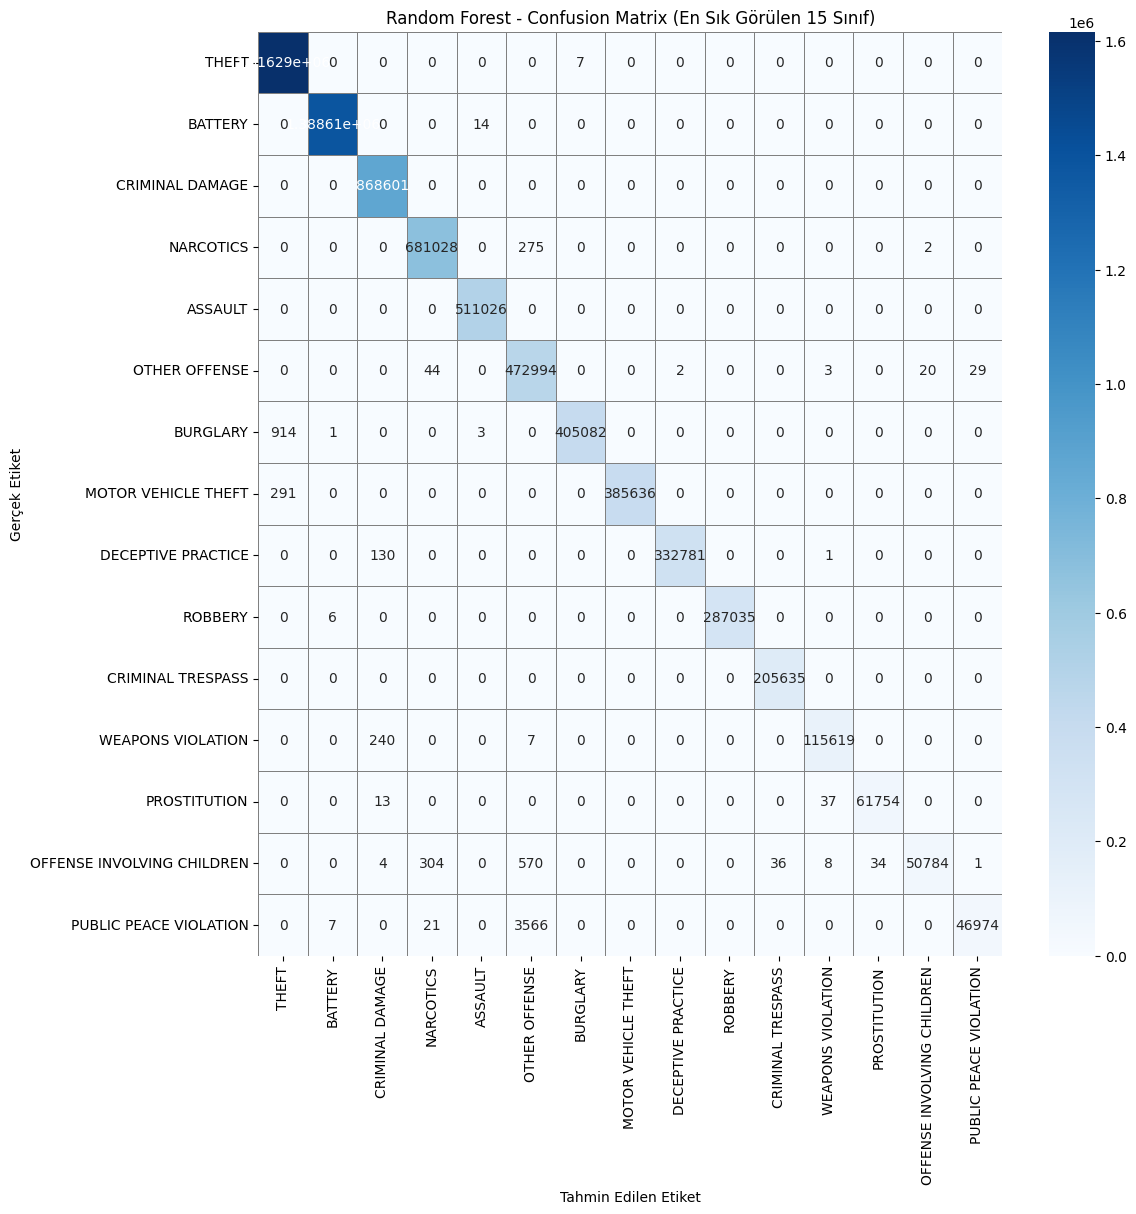

Görüntülenen çıkış son 5000 satıra kısaltıldı.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,1.283200e+04
1,0.160439,0.315886,0.212798,5.110260e+05
2,0.493958,0.310721,0.381476,1.388626e+06
3,0.090988,0.127810,0.106301,4.060000e+05
4,0.000000,0.000000,0.000000,1.505000e+03
5,0.582192,0.003564,0.007085,2.384800e+04
6,0.296758,0.255809,0.274766,8.686010e+05
7,0.007101,0.003746,0.004905,9.343000e+03
8,0.144915,0.116342,0.129066,2.056350e+05
9,0.068807,0.081755,0.074724,3.329200e+05



✅ LightGBM - Confusion Matrix Görselleştirmesi (En Sık Görülen 15 Sınıf İçin)


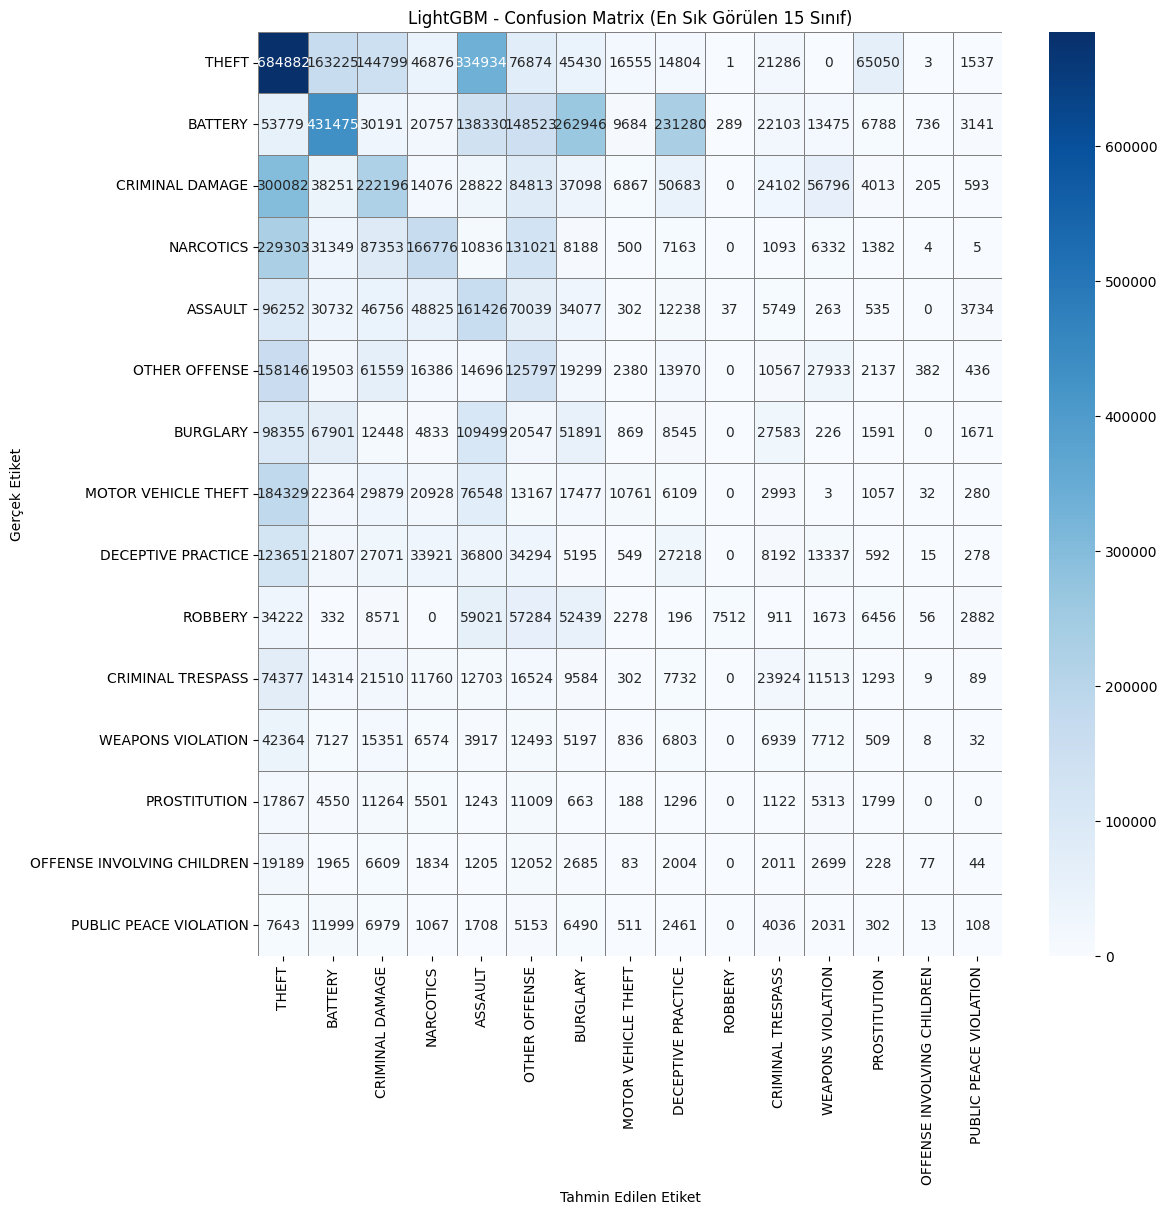



--- 🧪 XGBoost - Değerlendirme Başlıyor ---
[XGBoost] Cross-validation başlıyor...
[XGBoost] Cross-validation tamamlandı. Süre: 8676.13 saniye
[XGBoost] Tahminler alınıyor (cross_val_predict)...
[XGBoost] Tahminler alındı. Süre: 8930.72 saniye
Toplam Değerlendirme Süresi: 17609.78 saniye

✅ XGBoost - Genel Metrikler
Accuracy: 0.9980
Precision (Weighted): 0.9980
Recall (Weighted): 0.9980
F1 Score (Weighted): 0.9978

📋 XGBoost - Tüm sınıflar için Classification Report


,precision,recall,f1-score,support
0,0.999688,0.999532,0.999610,1.283200e+04
1,0.990712,0.999994,0.995331,5.110260e+05
2,0.999989,1.000000,0.999995,1.388626e+06
3,0.999376,0.997586,0.998480,4.060000e+05
4,0.846806,0.863123,0.854886,1.505000e+03
5,0.950519,0.986749,0.968295,2.384800e+04
6,1.000000,1.000000,1.000000,8.686010e+05
7,0.962533,0.868886,0.913315,9.343000e+03
8,1.000000,1.000000,1.000000,2.056350e+05
9,0.999994,1.000000,0.999997,3.329200e+05



✅ XGBoost - Confusion Matrix Görselleştirmesi (En Sık Görülen 15 Sınıf İçin)


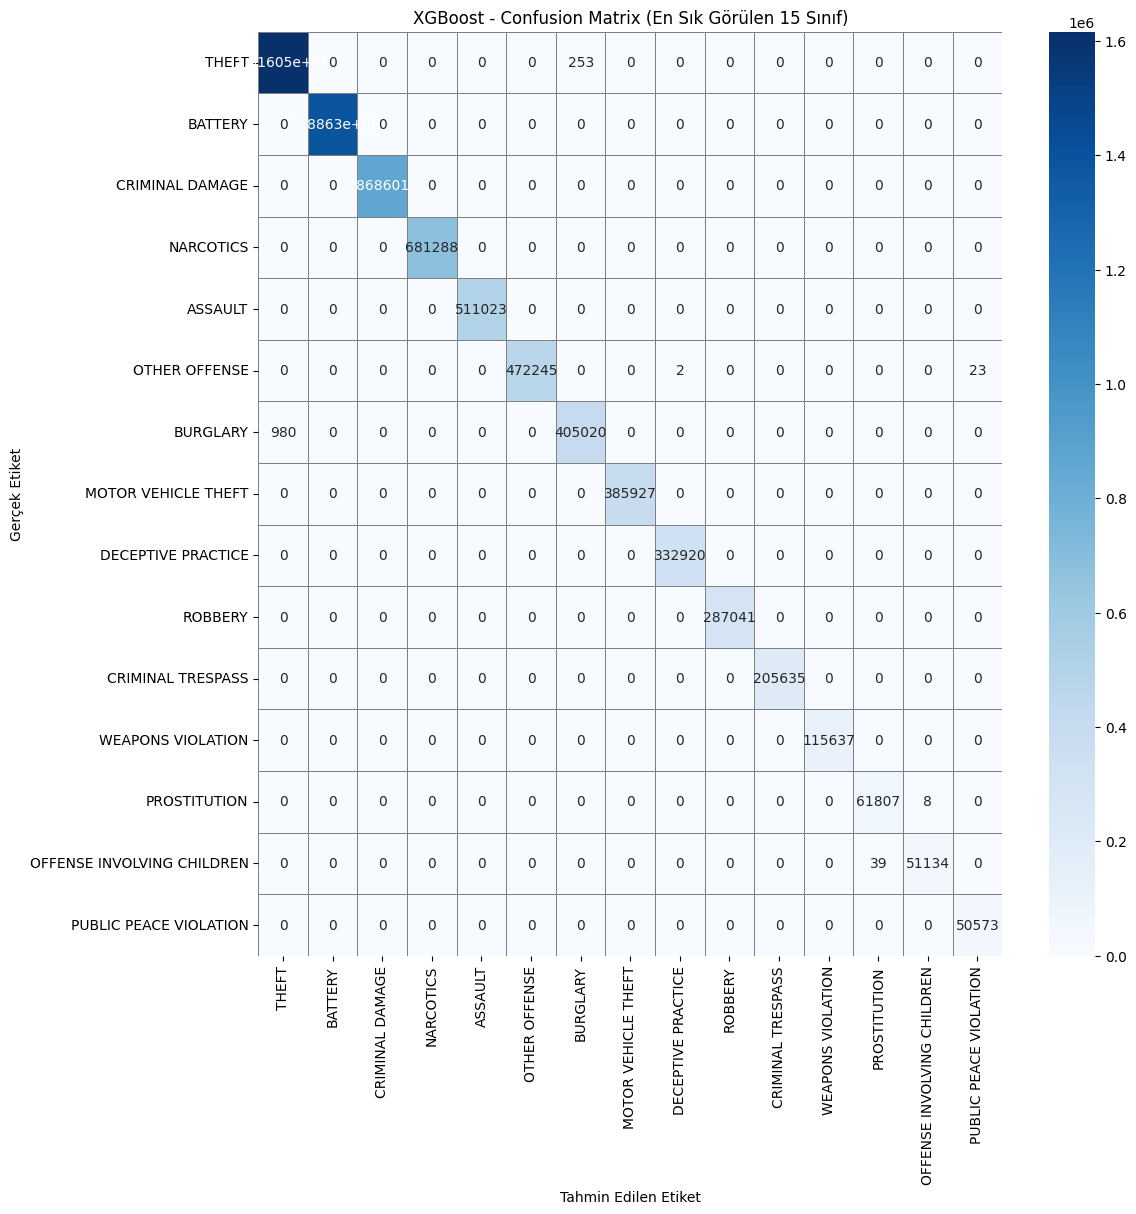

In [ ]:
n_classes = len(np.unique(y_array))
model_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=1, class_weight='balanced')
model_lgb = lgb.LGBMClassifier(objective='multiclass', num_class=n_classes, random_state=42, n_estimators=100, n_jobs=1, is_unbalance=True, silent=True)
model_xgb = XGBClassifier(objective='multi:softmax', num_class=n_classes, eval_metric='mlogloss', use_label_encoder=False, random_state=42, n_jobs=1)

models = [
    (model_rf, "Random Forest"),
    (model_lgb, "LightGBM"),
    (model_xgb, "XGBoost")
]

le_location_code_for_names = LabelEncoder()
le_location_code_for_names.fit(df['Location Description'])

for model, name in models:
    print(f"\n\n--- 🧪 {name} - Değerlendirme Başlıyor ---")
    start_time = time.time()
    result, y_pred_current_model = evaluate_model_primary(model, X_scaled, y_array, model_name=name)
    end_time = time.time()
    print(f"Toplam Değerlendirme Süresi: {end_time - start_time:.2f} saniye")

    print(f"\n✅ {name} - Genel Metrikler")
    print(f"Accuracy: {result['Accuracy']:.4f}")
    print(f"Precision (Weighted): {result['Precision']:.4f}")
    print(f"Recall (Weighted): {result['Recall']:.4f}")
    print(f"F1 Score (Weighted): {result['F1 Score']:.4f}")

    print(f"\n📋 {name} - Tüm sınıflar için Classification Report")
    class_names = le_primary.inverse_transform(np.unique(y_array))

    display(result['Classification Report'])

    print(f"\n✅ {name} - Confusion Matrix Görselleştirmesi (En Sık Görülen {min(15, n_classes)} Sınıf İçin)")

    top_n_classes = 15
    top_classes_indices = pd.Series(y_array).value_counts().head(top_n_classes).index.tolist()
    top_classes_names = le_primary.inverse_transform(top_classes_indices)

    sub_cm = confusion_matrix(y_array, y_pred_current_model, labels=top_classes_indices)

    plt.figure(figsize=(top_n_classes * 0.8, top_n_classes * 0.8))
    sns.heatmap(sub_cm,
                annot=True, fmt='g', cmap='Blues',
                xticklabels=top_classes_names,
                yticklabels=top_classes_names,
                linewidths=.5, linecolor='gray')
    plt.xlabel('Tahmin Edilen Etiket')
    plt.ylabel('Gerçek Etiket')
    plt.title(f'{name} - Confusion Matrix (En Sık Görülen {top_n_classes} Sınıf)')
    plt.show()

Bu çalışmada, Chicago suç verisi kullanılarak bir olayın ait olduğu suç kategorisinin tahmin edilmesi hedeflendi. Bu, çok sınıflı bir sınıflandırma problemidir ve sınıf sayısının fazla olması, sınıf dengesizliğiyle birleşince model başarımı açısından belirli zorlukları da beraberinde getirdi. Bu görevde üç farklı model kullanıldı: Random Forest, XGBoost ve LightGBM. Her bir modelin genel başarımı oldukça farklılık gösterdiği gibi, sınıf bazında yapılan detaylı incelemeler ciddi performans farklarını ortaya koydu.

Random Forest — Genelde Başarılı, Ancak Azınlık Sınıflarda Zayıf
Random Forest modeli, genel doğruluk ve F1 skoru açısından oldukça yüksek performans gösterdi (doğruluk: %99.75 civarı). Bu başarı, özellikle veri setindeki baskın sınıflarda kendini güçlü şekilde gösterdi. Örneğin, ‘THEFT’, ‘BATTERY’, ‘CRIMINAL DAMAGE’ gibi veri setinde çok sayıda örneğe sahip sınıflar için precision ve recall değerleri neredeyse 1.00 seviyesindeydi. Yani model bu sınıflarda hem çok doğru tahminler yaptı, hem de neredeyse tüm örnekleri doğru sınıflandırabildi.

Ancak, bu başarı azınlık sınıflara gelindiğinde ciddi biçimde düşmektedir. Class 21 ve 29 gibi örnek sayısı 10-15 civarında olan sınıflar için precision, recall ve F1 skorları sıfırdır; model bu sınıfları tamamen es geçmiş ve hiçbir örneği doğru tahmin edememiştir. Class 24 gibi 145 gözleme sahip sınıflarda recall %11’e kadar düşerken, Class 19 (n=38), Class 20 (n=179), Class 22 (n=849), Class 12 (n=115) gibi sınıflarda da benzer şekilde F1 skorları 0.5’in altındadır. Class 14 ve 15 gibi orta seviyede gözlem içeren sınıflarda dahi (n=4.000–6.000 arası) recall %44–50 civarına kadar inmiştir.

Karışıklık matrisine bakıldığında modelin baskın sınıflarda oldukça başarılı olduğu görülüyor; diyagonal elemanlar belirgin şekilde yüksek. Ancak, nadir suç türleri genellikle ya yanlış sınıflara atanıyor ya da tahmin dahi edilmiyor. Örneğin ‘PROSTITUTION’ sınıfının bazı örnekleri ‘WEAPONS VIOLATION’ olarak etiketlenmiş, ‘OFFENSE INVOLVING CHILDREN’ sınıfı hem kendi içinde hem de başka sınıflara yönelik hatalara açık. Bu tür hatalar, azınlık sınıfların model tarafından ya ayırt edilemediğini ya da yeterince temsil edilmediğini gösteriyor.

Sonuç olarak, Random Forest modeli sınıf dengesizliği nedeniyle azınlık sınıflarda ciddi hatalar yapmakta. class_weight='balanced' kullanılmış olsa da bu yaklaşım yeterli olmamış. Modelin güçlü yönü, yüksek gözlem sayısına sahip sınıflarda istikrarla çalışmasıdır. Zayıf yönü ise nadir suç türlerinde başarısız olmasıdır.

LightGBM — Genel Başarısızlık ve Aşırı Yanlı Tahmin
LightGBM modeli bu görevde ciddi bir başarısızlık örneği sergiledi. Doğruluk: %25.35, precision: %37.71 ve F1 skoru: %20.86 gibi oldukça düşük değerlere sahipti. Sadece azınlık sınıflarda değil, baskın sınıflarda da başarı gösterememesi modelin genel bir öğrenme sorunu yaşadığını gösteriyor.

Sınıf bazlı metrikler incelendiğinde durum daha da netleşiyor: birçok sınıf (örneğin Class 0, 4, 10, 12, 13, 14, 15, 16, 19, 20, 21, 22, 24, 27, 29, 31, 32) için precision, recall ve F1 skorları sıfır. Yani model bu sınıflarda tamamen başarısız. Daha da çarpıcısı, ‘THEFT’, ‘BATTERY’, ‘CRIMINAL DAMAGE’, ‘ASSAULT’ gibi baskın sınıflarda bile F1 skoru %30–40 bandında kalmış. Bu da modelin genel olarak hiçbir sınıfı anlamlı şekilde öğrenemediğini gösteriyor.

Karışıklık matrisinde tahminlerin büyük çoğunluğu birkaç sınıfa sıkışmış. Örneğin çok sayıda örnek ‘THEFT’ ya da ‘BATTERY’ olarak tahmin edilmiş. Ancak gerçek sınıfı ne olursa olsun, LightGBM genellikle en sık rastlanan birkaç sınıfa tahmin yapıyor. Bu durum, modelin sınıf dağılımı dengesizliklerini öğrenemediğini ve ciddi bir overfitting/underfitting dengesizliği yaşadığını ortaya koyuyor. Görsel olarak matrisin genelinin açık tonlarda olması, doğru tahmin sayısının düşük olduğunu da kanıtlıyor.

Bu performans düşüklüğünün nedeni olarak hiperparametre ayarlarının uygun olmaması veya modelin bu görev için gereğinden fazla basit veya kompleks kalması gibi sebepler öne sürülebilir. LightGBM’nin doğru çalışması için özel ağırlıklar, özelleştirilmiş loss fonksiyonları ya da sınıfa özel scale_pos_weight ayarlarının yapılması gerekebilir.

XGBoost — Güçlü ve Dengeli, Ancak Azınlık Sınıflarda Sınırlı
XGBoost modeli, genel doğruluk, precision, recall ve F1 skorları açısından Random Forest ile benzer, hatta biraz daha iyi bir performans sundu (doğruluk: %99.80, F1 skor: %99.78). Bu, modelin baskın sınıfları çok iyi öğrendiğini ve doğru tahmin ettiğini açıkça göstermekte.

Ancak, Random Forest’ta olduğu gibi burada da zayıf halkayı azınlık sınıflar oluşturuyor. Class 21 ve 29 gibi az gözlemli sınıflarda modelin precision ve recall değerleri sıfır. Ayrıca Class 24 (n=145), Class 19 (n=38), Class 20 (n=179), Class 22 (n=849), Class 27 (n=202), Class 32 (n=5468) gibi sınıflarda recall genellikle %40’ın altında, F1 skoru ise %0.3–0.5 aralığında kalıyor. Bu durum, modelin bu nadir sınıflarda yeterince güvenli kararlar veremediğini gösteriyor. Özellikle Class 32 gibi gözlem sayısı yüksek olan sınıflarda bile başarının düşük olması, daha dikkatli özellik mühendisliğine ihtiyaç olduğunu ortaya koyuyor.

Karışıklık matrisine bakıldığında, XGBoost’un da baskın sınıflarda çok güçlü tahminler yaptığı ve diyagonal elemanların oldukça yoğun olduğu görülüyor. Ancak hata yapan sınıflar yine benzer: ‘PROSTITUTION’, ‘OFFENSE INVOLVING CHILDREN’, ‘WEAPONS VIOLATION’ gibi sınıflar arasında az sayıda ama anlamlı hatalar gözlemleniyor. İlginç olan nokta ise bazı sınıflarda Random Forest’a göre daha az hata yapması; örneğin ‘WEAPONS VIOLATION’ sınıfında yanlışlıkla ‘BATTERY’ olarak tahmin edilen örnek sayısı sıfır.

XGBoost’un bu görevde Random Forest’tan biraz daha iyi çalışmasının temel nedenleri arasında daha güçlü optimizasyon, ağaç yapısının daha esnek olması ve örnek ağırlığına daha duyarlı yapısı sayılabilir. Ancak tüm güçlü yanlarına rağmen, azınlık sınıflarda başarım düşüklüğü hâlâ ciddi bir problemdir.

Bu analiz, üç modelin de baskın sınıflarda oldukça başarılı, fakat azınlık sınıflarda ciddi sorunlar yaşadığını ortaya koymaktadır. LightGBM, genel anlamda başarısız olmuştur ve ciddi hiperparametre ayarı, özelleştirme ve dengesiz veri için özel stratejiler gerektirmektedir.

Random Forest ve XGBoost ise sınıf dengesizliği problemini bir noktaya kadar çözebilmiş olsalar da, nadir suç türlerinde F1 skorlarının sıfıra yakın olması, modellerin bu sınıfları neredeyse yok saydığını göstermektedir.

Bu üç model arasında seçim yaparken yalnızca genel doğruluk ya da F1 skoruna bakmak yeterli değil. Bu noktada, modelin hangi tür hataları yaptığı, azınlık sınıflara nasıl davrandığı, hesaplama kaynaklarıyla ne kadar verimli çalıştığı ve uygulama senaryosunun ne olduğu gibi faktörler kritik hâle geliyor.

Eğer hedef, yalnızca baskın suç türlerini yüksek doğrulukla tahmin etmek ve genel başarıyı maksimize etmekse, hem Random Forest hem de XGBoost bu işi oldukça başarılı şekilde yapabiliyor. Ancak daha derine inildiğinde, XGBoost'un birkaç önemli avantajı öne çıkıyor. İlk olarak, XGBoost Random Forest’tan daha hızlı ve daha verimli çalışıyor. Bu, büyük veri setleriyle çalışırken ciddi bir avantaj. Ayrıca XGBoost, Random Forest’a kıyasla bazı orta seviye sınıflarda (örneğin Class 32 gibi destek değeri yüksek ama karmaşık sınıflarda) daha az hata yapıyor. Bununla birlikte Random Forest’ın azınlık sınıflarda biraz daha yüksek recall verdiği örnekler de var; bu da modelin biraz daha “risk alarak” nadir sınıfları tahmin etmeye çalıştığını gösteriyor.

Öte yandan LightGBM, bu görev özelinde tamamen elenmesi gereken bir model gibi duruyor. Hem genel başarıda çok düşük kalıyor hem de baskın sınıflar dahil olmak üzere çoğu sınıfı yanlış tahmin ediyor. Bu, modelin bu tip ciddi dengesizlik içeren çok sınıflı problemler için uygun şekilde yapılandırılmadığını ve daha fazla dengeye ihtiyaç duyduğunu gösteriyor. Belki farklı parametre ayarlarıyla ya da özel loss fonksiyonlarıyla bu model tekrar değerlendirilebilir, ancak şu anki haliyle kullanılamaz durumda.

Eğer daha hızlı, daha dengeli ve genelde daha doğru tahminler yapabilen bir model tercih edilecekse, XGBoost bu görev için en uygun seçenek olarak öne çıkıyor. Özellikle kaynak kısıtlı ortamlarda ya da üretim ortamına entegre edilmesi planlanan sistemlerde XGBoost’un sunduğu performans-verimlilik dengesi oldukça değerli. Ancak uygulamanın odak noktası, nadir suç türlerini özellikle yakalamaksa, Random Forest'a özel stratejiler (örneğin yeniden örnekleme, sınıfa özel ağırlıklandırma) uygulanarak o model de güçlendirilebilir. Fakat mevcut hâlleriyle değerlendirildiğinde, XGBoost hem genel hem de sınıf bazlı başarıda daha dengeli bir profil çizdiği için bu problem için en iyi tercih olarak öne çıkmaktadır.